# Лабораторная работа №3

## Градиентный бустинг деревьев решений

Рассмотрим качество работы алгоритмов градиентного бустинга деревьев решений в зависимости от настраиваемых гиперпараметров

В качестве датасета будем использовать данные из [соревнования на Kaggle](https://www.kaggle.com/competitions/playground-series-s4e10/overview) (определение выгодности предоставления кредита по данным из заявки на его получение)

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_auc_score, f1_score

In [3]:
from imblearn.over_sampling import RandomOverSampler

In [4]:
from core.visualiztion import *
from core.evaluation import *
from core.training import *
from core.reports.ModelInfo import *
from core.reports.TrainingReport import *

## Загрузка и первичный анализ данных

In [5]:
data_path = 'data'

In [6]:
train_df = pd.read_csv(f"{data_path}/train.csv", index_col=0)
train_df.sample(10)

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                          
9760           22          56000                  RENT                6.0   
37300          23          38400                  RENT                3.0   
39623          26          40000                   OWN                0.0   
22263          26         122000                  RENT                7.0   
45387          23          50000                  RENT                7.0   
36131          31         135000              MORTGAGE                9.0   
57719          23         115275                  RENT                7.0   
41830          32          42000                  RENT                1.0   
18765          22          35400                  RENT                4.0   
21852          21          62004                  RENT                0.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  \
id                                                            
9760           VENTURE          B       5000          12.18   
37300          VENTURE          A      13000           8.49   
39623          VENTURE          A       1800           7.51   
22263  HOMEIMPROVEMENT          C      14000          13.48   
45387        EDUCATION          B       4000          10.00   
36131  HOMEIMPROVEMENT          C      15000          13.85   
57719          VENTURE          C       7500          11.28   
41830          VENTURE          B       3000          10.00   
18765        EDUCATION          C       9600          13.16   
21852        EDUCATION          A      15000           7.88   

       loan_percent_income cb_person_default_on_file  \
id                                                     
9760                  0.09                         N   
37300                 0.35                         N   
39623                 0.04                         N   
22263                 0.11                         N   
45387                 0.08                         N   
36131                 0.11                         N   
57719                 0.07                         Y   
41830                 0.07                         N   
18765                 0.27                         N   
21852                 0.24                         N   

       cb_person_cred_hist_length  loan_status  
id                                              
9760                            2            0  
37300                           3            1  
39623                           3            0  
22263                           3            0  
45387                           2            0  
36131                          10            0  
57719                           2            0  
41830                           9            0  
18765                           4            0  
21852                           4            0

Посмотрим на размер датасета и типы данных столбцов

In [7]:
train_df.shape

(58645, 12)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


Датасет состоит преимущественно из числовых столбцов, также имеется ряд строковых. Рассмотрим числовые характеристики каждых чтобы выделить возможные категориальные столбцы

In [9]:
train_df.describe().T

count          mean           std      min  \
person_age                  58645.0     27.550857      6.033216    20.00   
person_income               58645.0  64046.172871  37931.106979  4200.00   
person_emp_length           58645.0      4.701015      3.959784     0.00   
loan_amnt                   58645.0   9217.556518   5563.807384   500.00   
loan_int_rate               58645.0     10.677874      3.034697     5.42   
loan_percent_income         58645.0      0.159238      0.091692     0.00   
cb_person_cred_hist_length  58645.0      5.813556      4.029196     2.00   
loan_status                 58645.0      0.142382      0.349445     0.00   

                                 25%       50%       75%         max  
person_age                     23.00     26.00     30.00      123.00  
person_income               42000.00  58000.00  75600.00  1900000.00  
person_emp_length               2.00      4.00      7.00      123.00  
loan_amnt                    5000.00   8000.00  12000.00    35000.00  
loan_int_rate                   7.88     10.75     12.99       23.22  
loan_percent_income             0.09      0.14      0.21        0.83  
cb_person_cred_hist_length      3.00      4.00      8.00       30.00  
loan_status                     0.00      0.00      0.00        1.00

Здесь можно заметить, что большинство измерений лежит примерно в одном диапазоне, исключениями являются размер кредита и доход получателя, отличающиеся от остальных значений на порядки. Однако поскольку градиентный бустинг устойчив к разнице в масштабах данных - операцию масштабирования проводить не будем

In [10]:
train_df.select_dtypes(include=["object"]).describe()

person_home_ownership loan_intent loan_grade cb_person_default_on_file
count                  58645       58645      58645                     58645
unique                     4           6          7                         2
top                     RENT   EDUCATION          A                         N
freq                   30594       12271      20984                     49943

По числу уникальных значений у строковых измерений можно сделать вывод, что все они являются категориями, поэтому в дальнейшем мы применим к ним различные операции кодирования

Построим круговые диаграммы для данных категорий и для целевой переменной, чтобы посмотреть на распределение данных по этим измерениям

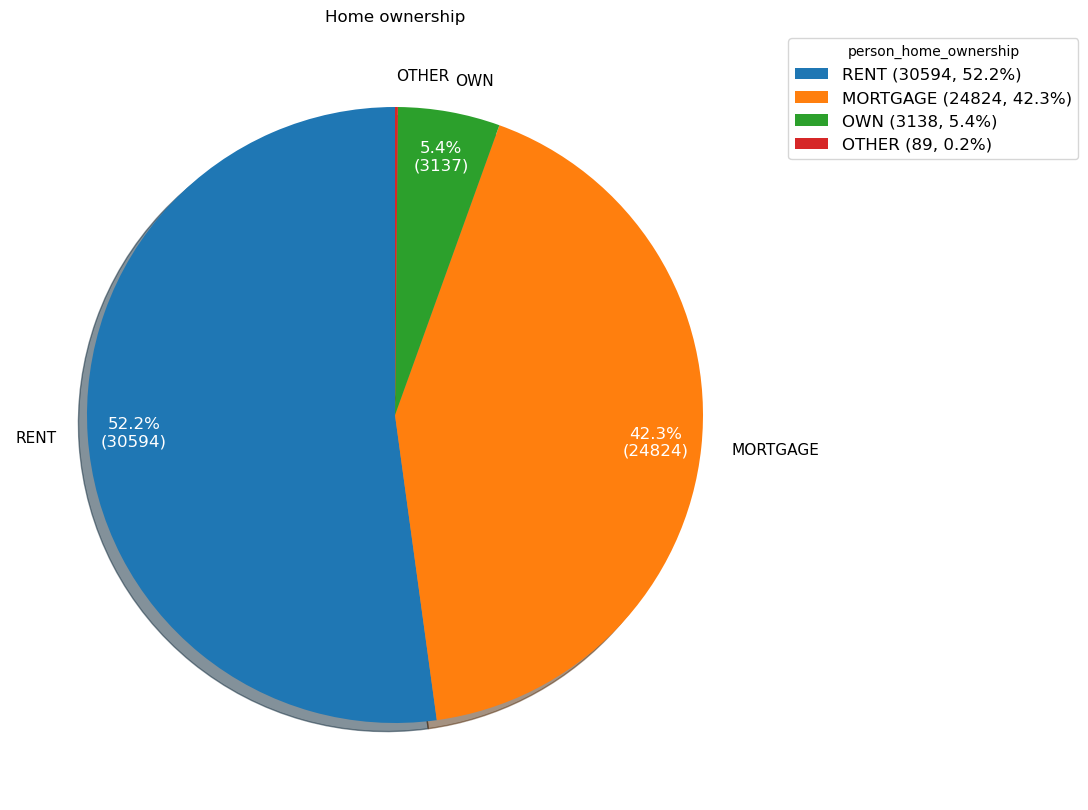

In [11]:
plot_pie_chart(data=train_df, column='person_home_ownership', title='Home ownership')

На диаграмме можно заметить, что подавляющее число кредитополучателей снимают жилье, либо имеют его в ипотеку. Около 5% имеют собственное жилье и об исчезающе малом проценте кредитополучателей (касательно их жилья) информации нет

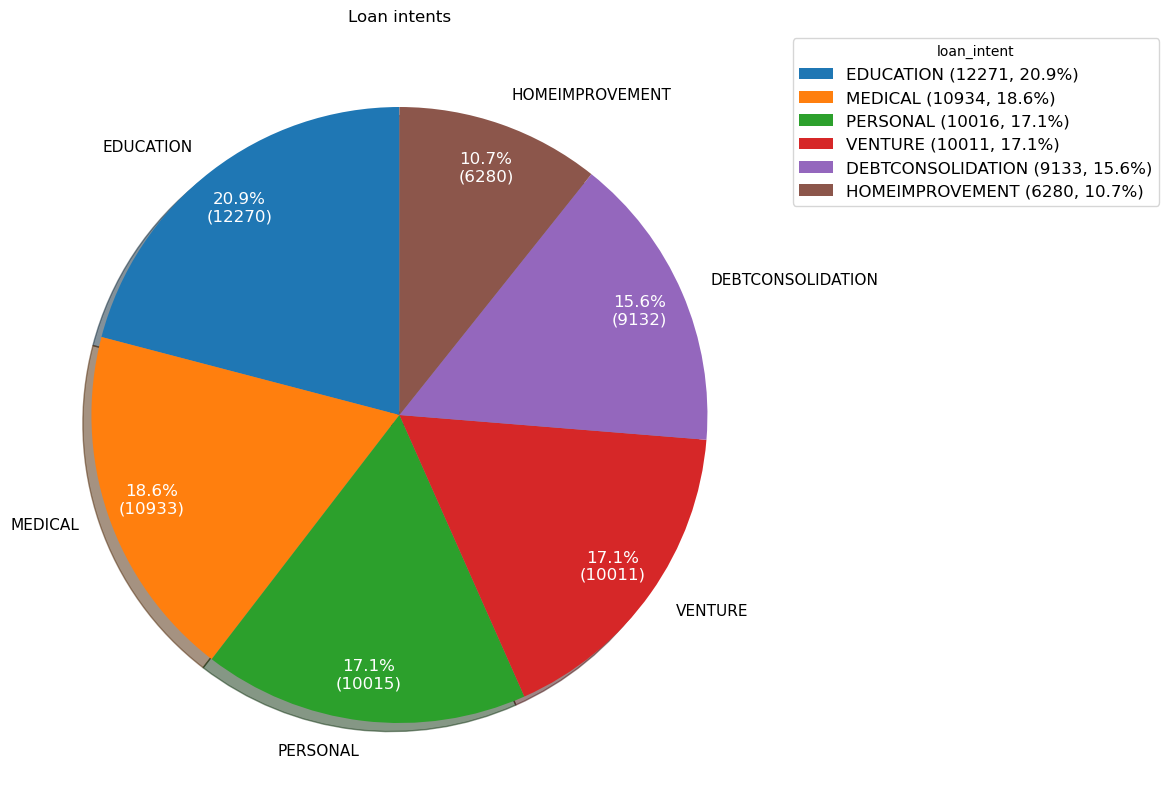

In [12]:
plot_pie_chart(data=train_df, column='loan_intent', title='Loan intents')

Цели, для которых берутся кредиты, распределены примерно равномерно. Наибольшее число кредитов берется на образование, меньшая их часть - на улучшение жилища 

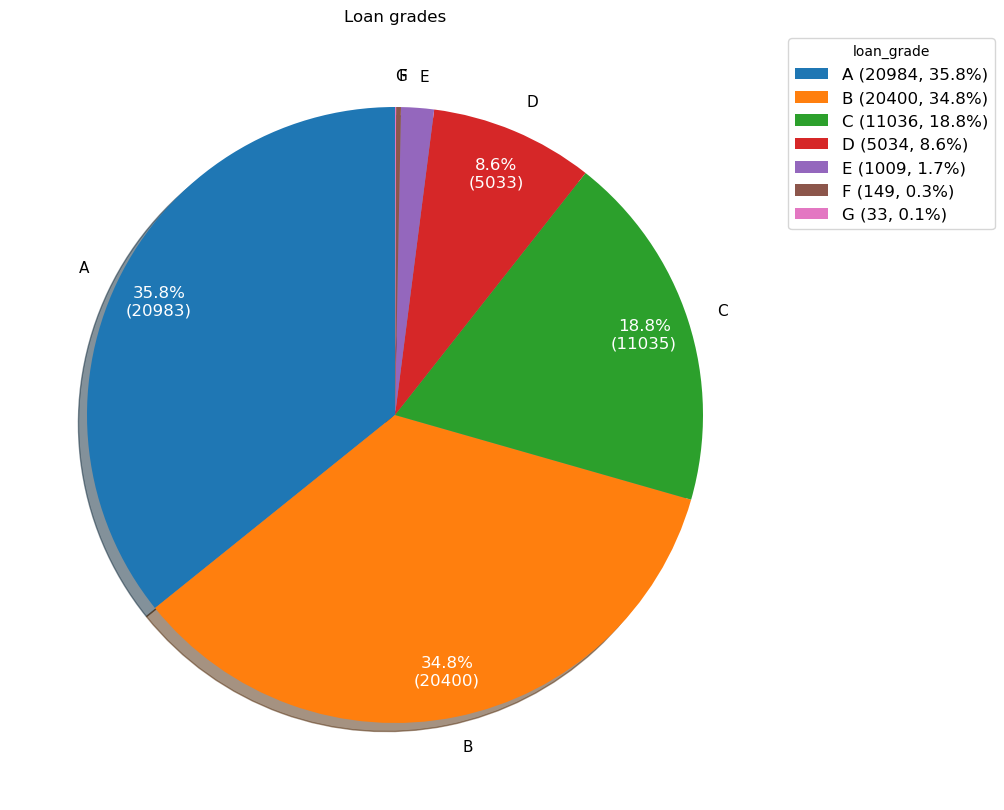

In [13]:
plot_pie_chart(data=train_df, column='loan_grade', title='Loan grades')

Большинство оценок риска для кредитов являются минимальными, оценок, говорящих о большем риске при выдаче кредита становится все меньше и меньше. Самую "высокую" рискованность имеет 0.1% всех заявок на кредит

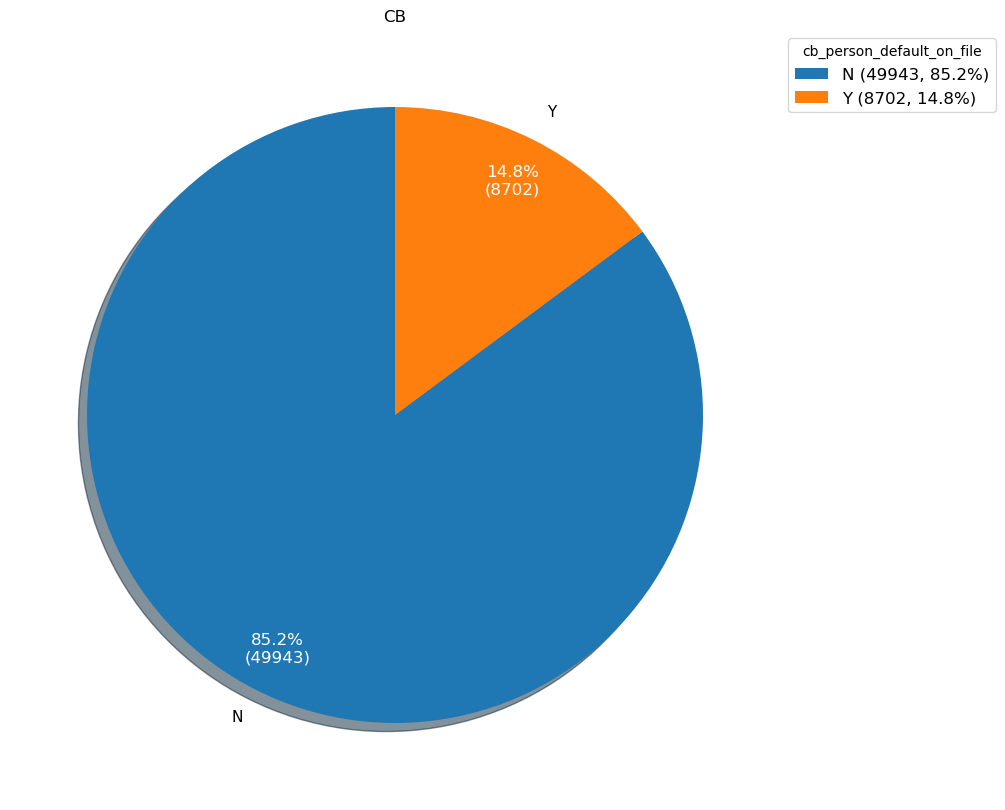

In [14]:
plot_pie_chart(data=train_df, column='cb_person_default_on_file', title='CB')

Подавляющее большинство кредитополучателей не зарегистрированны в базе данных кредитных дефолтов, то есть не имеют просрочек по кредитам

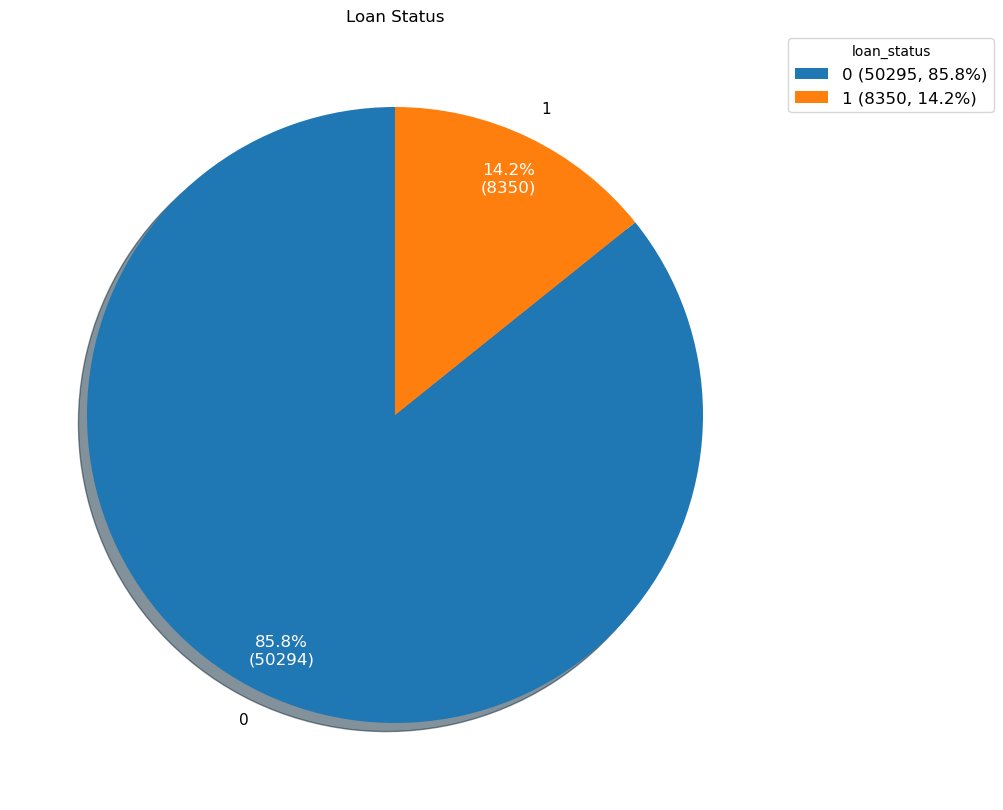

In [15]:
plot_pie_chart(data=train_df, column='loan_status', title='Loan Status')

Целевая переменная (статус кредита) в подавляющем большинстве случаев имеет негативное значение, что говорит нам о том, что необходимо использовать выравнивающие стратегии сэмплирования и/или использовать метрики, устойчивые к скошенному распределению (например `f1_score`)

Поскольку перед нами стоит задача бинарной классификации - мы можем использовать классический `f1_score`. Кроме того, мы будем предсказывать вероятностное распределение классов и оценивать его качество (по вероятности положительного класса) с помощью `roc_auc_score`, что позволяет решать практическую задачу более гибко (использовать threshold'ы), а также продиктовано требованиями соревнования

Посмотрим на корреляции между числовыми переменными

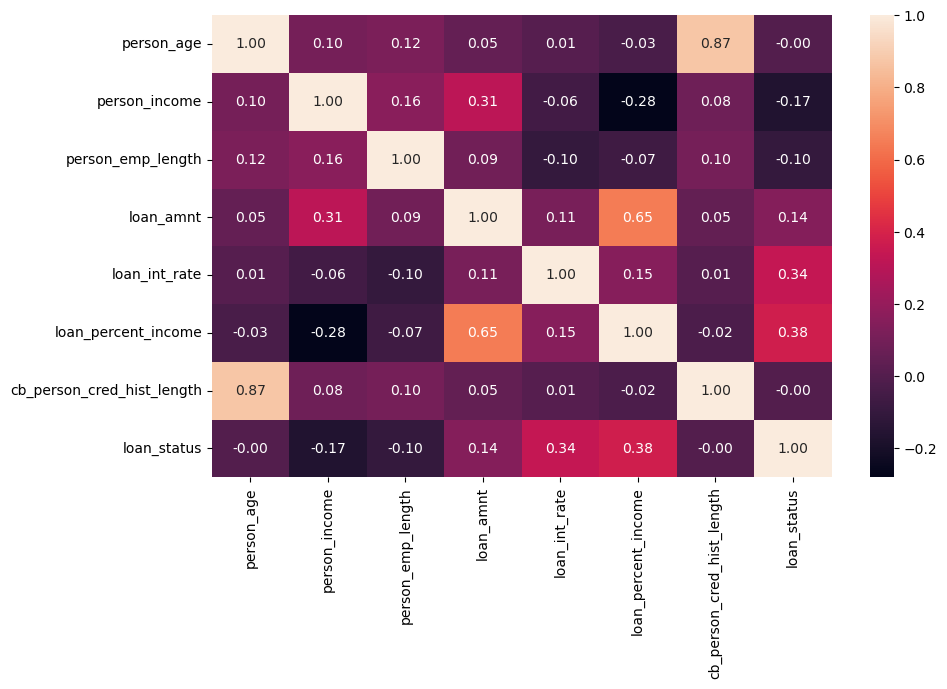

In [16]:
correlations = train_df.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.show()

Большинство корреляций являются слабыми, исключением является связь между размером кредита и отношением суммы кредита к доходу заемщика в процентах, что логично

Поскольку максимальная корреляция не превосходит `0.8` и, кроме того, градиентный бустинг достаточно устойчив к линейным зависимостям между переменными - мы не будем проводить дополнительную обработку данных, направленную на уменьшение коэффициентов корреляции между переменными

## Подготовка данных для обучения модели

Создадим копию исходного датасета

In [17]:
train_df_prepared = train_df.copy()
train_df_prepared.sample(10)

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                          
48615          26          65000              MORTGAGE                0.0   
42497          27          27000                  RENT                0.0   
35456          25          32000                  RENT                3.0   
5518           26          40000                  RENT                2.0   
25905          28          61000              MORTGAGE               12.0   
47281          24          30000                  RENT                3.0   
33377          27         100000                  RENT                0.0   
14404          25          95000              MORTGAGE                9.0   
14903          22          38000              MORTGAGE                5.0   
48442          23          39996                  RENT                1.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  \
id                                                            
48615          VENTURE          A       6000           7.51   
42497         PERSONAL          D       5000          15.33   
35456          MEDICAL          A       4800           7.14   
5518           MEDICAL          A       6000           7.88   
25905          MEDICAL          A      12000           6.17   
47281          MEDICAL          B       4000          10.36   
33377  HOMEIMPROVEMENT          B      20000          11.48   
14404          MEDICAL          A      10000           7.88   
14903         PERSONAL          C       4800          14.79   
48442          VENTURE          B       1500          10.37   

       loan_percent_income cb_person_default_on_file  \
id                                                     
48615                 0.09                         N   
42497                 0.18                         Y   
35456                 0.15                         N   
5518                  0.15                         N   
25905                 0.20                         N   
47281                 0.13                         N   
33377                 0.20                         N   
14404                 0.11                         N   
14903                 0.12                         N   
48442                 0.04                         N   

       cb_person_cred_hist_length  loan_status  
id                                              
48615                           4            0  
42497                           6            1  
35456                           3            0  
5518                            4            0  
25905                           8            0  
47281                           3            0  
33377                           7            0  
14404                           2            0  
14903                           3            0  
48442                           3            0

Способ владения недвижимостью и цель заема не имеют иерархического порядка следования, потому для их кодировки применим `one_hot_encoding`

In [18]:
one_hot_columns = ['person_home_ownership', 'loan_intent']
train_df_prepared = pd.get_dummies(train_df_prepared, columns=one_hot_columns, drop_first=False)
train_df_prepared.sample(10)

person_age  person_income  person_emp_length loan_grade  loan_amnt  \
id                                                                          
57250          23          95000                1.0          C      10000   
25066          23          30000                4.0          B       1500   
7390           29          54000               13.0          A       6000   
16820          30          90000                2.0          A      10000   
10853          24          30000                5.0          A      10000   
30485          42          70000                3.0          B      19600   
15334          33          30000                0.0          A      10000   
40403          28         100000                7.0          F      15000   
25683          25         130000                8.0          B      20000   
46578          23          98000                7.0          D      20000   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
id                                                                    
57250          14.65                 0.11                         Y   
25066           9.91                 0.05                         N   
7390            6.92                 0.11                         N   
16820           8.10                 0.11                         N   
10853           6.99                 0.33                         N   
30485          12.42                 0.27                         N   
15334           7.66                 0.33                         N   
40403          18.43                 0.15                         Y   
25683          12.21                 0.15                         N   
46578          14.11                 0.20                         N   

       cb_person_cred_hist_length  loan_status  \
id                                               
57250                           3            0   
25066                           4            0   
7390                           10            0   
16820                           6            0   
10853                           4            1   
30485                          12            0   
15334                           9            1   
40403                           5            0   
25683                           3            0   
46578                           4            1   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
id                                                                   
57250                            True                        False   
25066                            True                        False   
7390                             True                        False   
16820                           False                        False   
10853                           False                        False   
30485                            True                        False   
15334                           False                        False   
40403                           False                        False   
25683                            True                        False   
46578                            True                        False   

       person_home_ownership_OWN  person_home_ownership_RENT  \
id                                                             
57250                      False                       False   
25066                      False                       False   
7390                       False                       False   
16820                      False                        True   
10853                      False                        True   
30485                      False                       False   
15334                      False                        True   
40403                      False                        True   
25683                      False                       False   
46578                      False                       False   

       loan_intent

Кредитный риск, выраженный в категориях от A до G имеет иерархический порядок следования, возможный кредит с риском A это не одно и то же, что кредит с риском G, поэтому для кодировки данной переменной применим `ordinal encoding`

Выделим возможные значения категорий и отсортируем их

In [19]:
grades = [np.sort(train_df_prepared['loan_grade'].unique()).tolist()]
grades

[['A', 'B', 'C', 'D', 'E', 'F', 'G']]

Подготовим кодировщик и закодируем данную переменную

In [20]:
ordinal_encoder = OrdinalEncoder(categories=grades)
ordinal_encoder.get_params()

{'categories': [['A', 'B', 'C', 'D', 'E', 'F', 'G']],
 'dtype': numpy.float64,
 'encoded_missing_value': nan,
 'handle_unknown': 'error',
 'max_categories': None,
 'min_frequency': None,
 'unknown_value': None}

In [21]:
train_df_prepared['loan_grade_encoded'] = ordinal_encoder.fit_transform(train_df_prepared[['loan_grade']])
train_df_prepared = train_df_prepared.drop('loan_grade', axis=1)
train_df_prepared.sample(10)

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
id                                                                              
48985          25          69000                0.0       3900          14.61   
35744          37          38400                3.0       2500          12.98   
17095          40          60000                5.0      12000          11.71   
54953          23          70000                0.0       8000           6.54   
49301          32          65000                2.0       7000          11.49   
4339           24          65000                8.0       8000          11.49   
20692          25         120000                3.0       8000           9.63   
22538          31          40000                2.0       5000           6.92   
48138          37         100000               11.0       6000           7.88   
41643          23          43000                4.0       8000           9.99   

       loan_percent_income cb_person_default_on_file  \
id                                                     
48985                 0.06                         Y   
35744                 0.07                         Y   
17095                 0.20                         N   
54953                 0.11                         N   
49301                 0.11                         N   
4339                  0.12                         N   
20692                 0.07                         N   
22538                 0.13                         N   
48138                 0.06                         N   
41643                 0.19                         N   

       cb_person_cred_hist_length  loan_status  \
id                                               
48985                           4            1   
35744                          14            0   
17095                          13            0   
54953                           2            0   
49301                           6            0   
4339                            2            0   
20692                           2            0   
22538                           7            1   
48138                          16            0   
41643                           4            0   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
id                                                                   
48985                           False                        False   
35744                           False                        False   
17095                           False                        False   
54953                           False                        False   
49301                           False                        False   
4339                            False                        False   
20692                            True                        False   
22538                           False                        False   
48138                            True                        False   
41643                           False                        False   

       person_home_ownership_OWN  person_home_ownership_RENT  \
id                                                             
48985                      False                        True   
35744                      False                        True   
17095                      False                        True   
54953                      False                        True   
49301                      False                        True   
4339                       False                        True   
20692                      False                       False   
22538                      False                        True   
48138                      False                       False   
41643                      False                        True   

       loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
id                                                            
48985                   

Для кодирования нахождения заемщика в базе данных кредитных дефолтов используем бинарное кодирование

In [22]:
train_df_prepared['cb_person_default_on_file_encoded'] = train_df_prepared['cb_person_default_on_file']\
    .map({'N': False, 'Y': True})
train_df_prepared = train_df_prepared.drop('cb_person_default_on_file', axis=1)
train_df_prepared.sample(10)

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
id                                                                              
31548          29          74400                9.0       5000          10.71   
41108          23          63000                7.0      25000          13.75   
33848          29          75000                1.0      10000          13.47   
41841          23          66000                1.0      20000          14.59   
41748          24          25000                0.0       7500           8.38   
3225           26          70000                7.0       2100           6.39   
57868          29          35000                2.0       6000           7.51   
55735          34          51000                8.0      20000          10.25   
40365          24          72000                8.0      12000           6.62   
5955           36          42000                2.0       6000          10.39   

       loan_percent_income  cb_person_cred_hist_length  loan_status  \
id                                                                    
31548                 0.07                           5            0   
41108                 0.40                           2            1   
33848                 0.13                           5            0   
41841                 0.30                           3            1   
41748                 0.30                           3            0   
3225                  0.03                           2            0   
57868                 0.17                           7            0   
55735                 0.39                           8            1   
40365                 0.17                           2            0   
5955                  0.14                          13            0   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
id                                                                   
31548                           False                        False   
41108                            True                        False   
33848                           False                        False   
41841                           False                        False   
41748                           False                        False   
3225                             True                        False   
57868                           False                        False   
55735                           False                        False   
40365                            True                        False   
5955                            False                        False   

       person_home_ownership_OWN  person_home_ownership_RENT  \
id                                                             
31548                       True                       False   
41108                      False                       False   
33848                      False                        True   
41841                      False                        True   
41748                       True                       False   
3225                       False                       False   
57868                      False                        True   
55735                      False                        True   
40365                      False                       False   
5955                       False                        True   

       loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
id                                                            
31548                          False                  False   
41108                           True                  False   
33848                          False                   True   
41841                          False                  False   
41748                          False                  False   
3225                           False                  False   
57868                          False                  False   
5573

Вновь посмотрим на типы данных

In [23]:
train_df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_age                         58645 non-null  int64  
 1   person_income                      58645 non-null  int64  
 2   person_emp_length                  58645 non-null  float64
 3   loan_amnt                          58645 non-null  int64  
 4   loan_int_rate                      58645 non-null  float64
 5   loan_percent_income                58645 non-null  float64
 6   cb_person_cred_hist_length         58645 non-null  int64  
 7   loan_status                        58645 non-null  int64  
 8   person_home_ownership_MORTGAGE     58645 non-null  bool   
 9   person_home_ownership_OTHER        58645 non-null  bool   
 10  person_home_ownership_OWN          58645 non-null  bool   
 11  person_home_ownership_RENT         58645 non-null  bool   


Как видно, все переменные имеют либо числовой, либо булевый тип данных, что говорит о возможности построения классификатора на имеющихся данных

Выделим признаки и целевую переменную

In [24]:
X = train_df_prepared.drop(columns=['loan_status'])
y = train_df_prepared['loan_status']

Еще раз посмотрим на распределение целевых меток

In [25]:
y.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

Мы видим скошеное распределение с которым необходимо что-то делать. Воспользуемся технологией оверсэмплинга, клонирующей случайные экземпляры минорного класса до тех пор, пока количество экземпляров классов не сравняется

In [26]:
ros = RandomOverSampler()
X_oversampled, y_oversampled = ros.fit_resample(X, y)

In [27]:
y_oversampled.value_counts()

loan_status
0    50295
1    50295
Name: count, dtype: int64

Теперь классы распределены равномерно

## Обучение классификатора

Разделим данные на тренировочную и тестовую выборки в соотношении 80/20

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=42)

В качестве эксперимента мы будем искать оптимальную комбинацию параметров `n_estimators`, `learning_rate`, `loss` и `subsample`. Лучшую модель будем выбирать по `roc_auc_score` на тестовой подвыборке

Укажем перебираемые значения для поиска оптимальной комбинации параметров

In [29]:
trees_numbers = [1000, 800]
learning_rates = [0.1, 0.05, 0.02, 0.25]
losses = ['log_loss', 'exponential']
subsample_sizes = [1, 0.65]

Инициализируем процесс тренировки и выполним ее

In [30]:
trainer = GBModelTrainer(
    train_x=X_train, 
    train_y=y_train, 
    test_x=X_test, 
    test_y=y_test, 
    trees_numbers=trees_numbers, 
    learning_rates=learning_rates, 
    losses=losses, 
    subsample_sizes=subsample_sizes, 
    random_state=42
)

In [31]:
%%time
training_report, best_classifier = trainer.train()

CPU times: total: 44min 42s
Wall time: 44min 52s


После 44-х минут обучения получим следующий отчет

In [32]:
training_report.to_frame()

model_name  train_score  train_f1  \
14   model_log_loss_1000_trees_0.25_lr_0.65_subsample     0.949510  0.949240   
12      model_log_loss_1000_trees_0.25_lr_1_subsample     0.947535  0.947126   
13   model_exponential_1000_trees_0.25_lr_1_subsample     0.936027  0.935147   
15  model_exponential_1000_trees_0.25_lr_0.65_subs...     0.936413  0.935594   
30    model_log_loss_800_trees_0.25_lr_0.65_subsample     0.943359  0.942888   
28       model_log_loss_800_trees_0.25_lr_1_subsample     0.941048  0.940405   
29    model_exponential_800_trees_0.25_lr_1_subsample     0.929864  0.928633   
31  model_exponential_800_trees_0.25_lr_0.65_subsa...     0.929926  0.928760   
2     model_log_loss_1000_trees_0.1_lr_0.65_subsample     0.923539  0.922072   
3   model_exponential_1000_trees_0.1_lr_0.65_subsa...     0.915561  0.913430   
0        model_log_loss_1000_trees_0.1_lr_1_subsample     0.920991  0.919366   
1     model_exponential_1000_trees_0.1_lr_1_subsample     0.914393  0.912156   
18     model_log_loss_800_trees_0.1_lr_0.65_subsample     0.918667  0.916808   
16        model_log_loss_800_trees_0.1_lr_1_subsample     0.915983  0.913985   
19  model_exponential_800_trees_0.1_lr_0.65_subsample     0.911721  0.909304   
17     model_exponential_800_trees_0.1_lr_1_subsample     0.908751  0.906125   
6    model_log_loss_1000_trees_0.05_lr_0.65_subsample     0.908204  0.905577   
4       model_log_loss_1000_trees_0.05_lr_1_subsample     0.906887  0.904129   
7   model_exponential_1000_trees_0.05_lr_0.65_subs...     0.901941  0.898650   
22    model_log_loss_800_trees_0.05_lr_0.65_subsample     0.903221  0.899990   
5    model_exponential_1000_trees_0.05_lr_1_subsample     0.899543  0.895959   
20       model_log_loss_800_trees_0.05_lr_1_subsample     0.902513  0.899293   
23  model_exponential_800_trees_0.05_lr_0.65_subsa...     0.896983  0.892983   
21    model_exponential_800_trees_0.05_lr_1_subsample     0.895951  0.892004   
10   model_log_loss_1000_trees_0.02_lr_0.65_subsample     0.887862  0.882975   
8       model_log_loss_1000_trees_0.02_lr_1_subsample     0.887427  0.882505   
11  model_exponential_1000_trees_0.02_lr_0.65_subs...     0.885003  0.879812   
9    model_exponential_1000_trees_0.02_lr_1_subsample     0.884854  0.879687   
26    model_log_loss_800_trees_0.02_lr_0.65_subsample     0.883661  0.878346   
24       model_log_loss_800_trees_0.02_lr_1_subsample     0.881661  0.876049   
27  model_exponential_800_trees_0.02_lr_0.65_subsa...     0.880928  0.875461   
25    model_exponential_800_trees_0.02_lr_1_subsample     0.879834  0.873967   

    train_roc_auc  test_score   test_f1  test_roc_auc  
14       0.989003    0.939755  0.939364      0.984960  
12       0.988288    0.936872  0.936354      0.984321  
13       0.987328    0.929267  0.928077      0.984129  
15       0.987416    0.930460  0.929404      0.983572  
30       0.986913    0.935431  0.934740      0.983327  
28       0.986292    0.932797  0.932019      0.982574  
29       0.985206    0.925291  0.923733      0.982525  
31       0.985198    0.924694  0.923225      0.981905  
2        0.980003    0.920270  0.918488      0.978059  
3        0.978652    0.913809  0.911377      0.977054  
0        0.978836    0.918133  0.916213      0.976880  
1        0.977827    0.913858  0.911360      0.976293  
18       0.977639    0.915847  0.913600      0.976190  
16       0.976660    0.914057  0.911817      0.975175  
19       0.976229    0.909086  0.906287      0.975052  
17       0.975394    0.909186  0.906312      0.974341  
6        0.972496    0.907048  0.904083      0.971970  
4        0.971478    0.906651  0.903742      0.971019  
7        0.970918    0.902177  0.898651      0.970602  
22       0.969866    0.902972  0.899568      0.969767  
5        0.970000    0.900089  0.896306      0.969734  
20       0.968962    0.902774  0.899403      0.968985  
23       0.968065    0.897107  0.892979      0.968062  
21       0.967605    0.897704  0.893676      0.967734  
10

Лучший результат показали модели, имеющие 1000 деревьев (наибольшее значение из анализируемых), самую высокую скорость обучения, функцию потерь log_loss. Доля обучающей выборки для обучения конкретного решающего дерева большой роли не сыграла, однако меньшие значения показывают чуть лучший результат

Построим графики изменения f1-меры, ROC AUC score и значения функции потерь в зависимости от итерации для каждой из комбинаций параметров

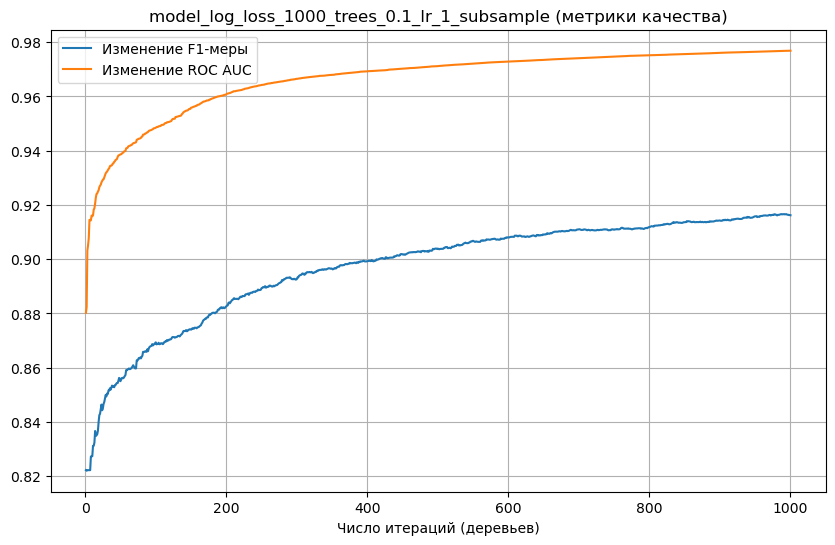

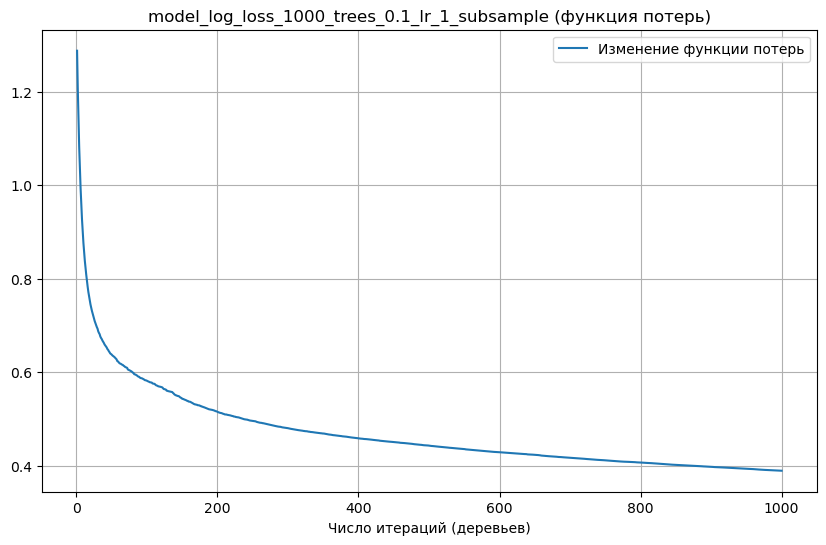

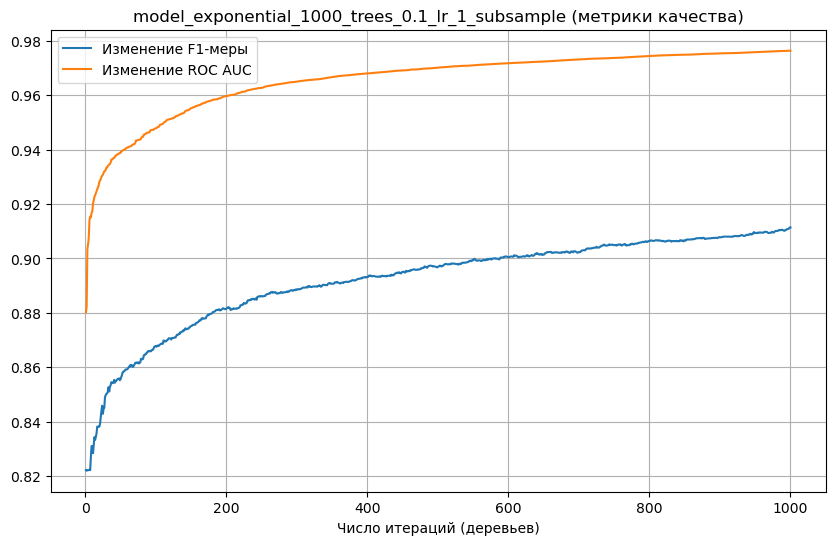

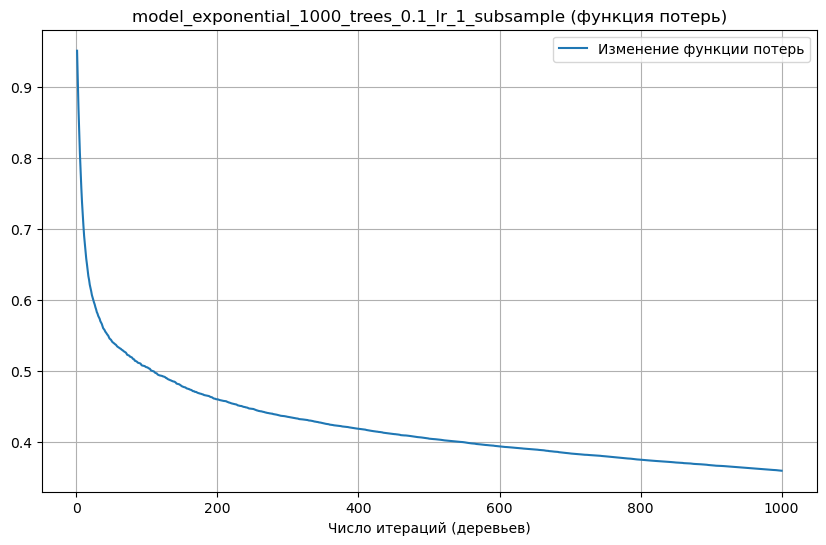

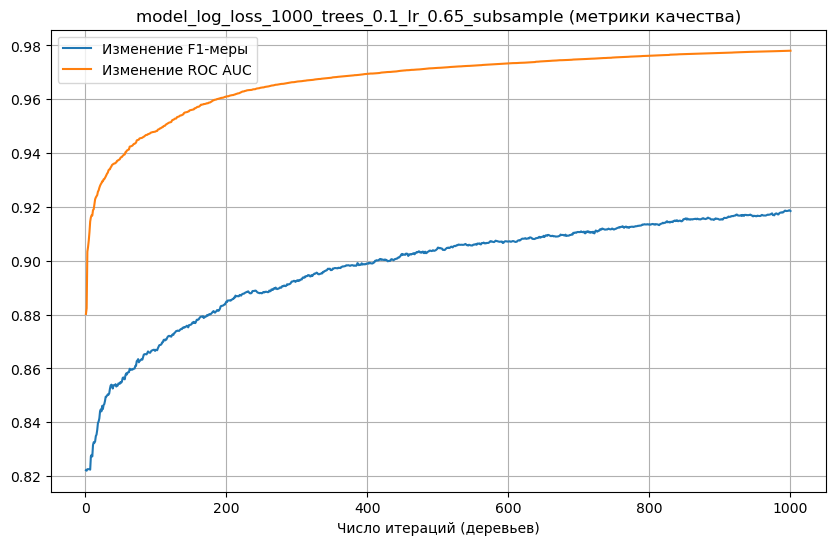

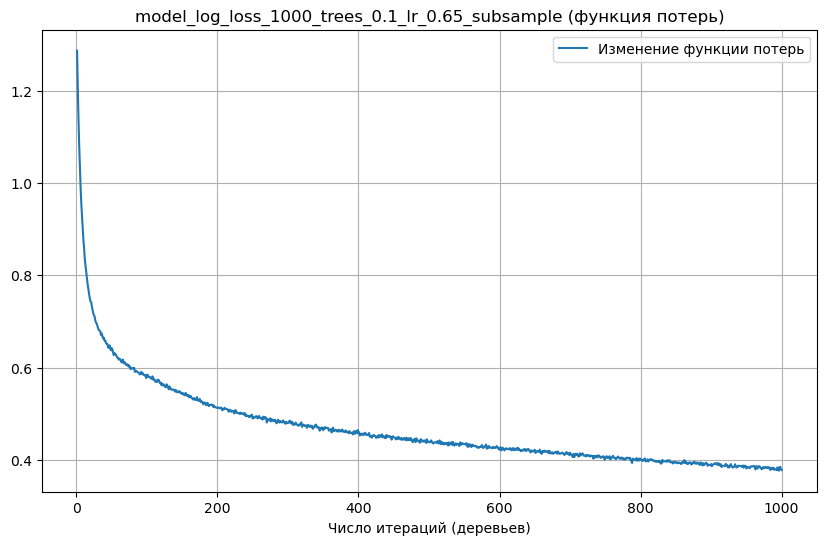

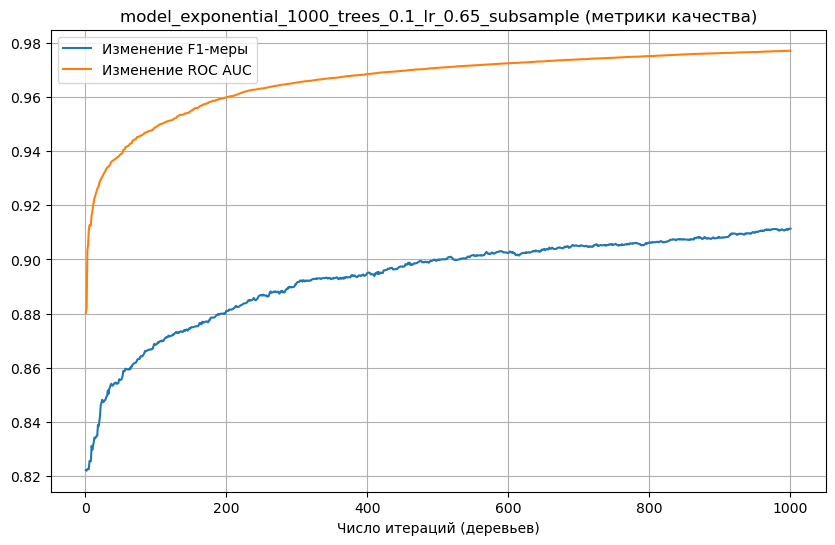

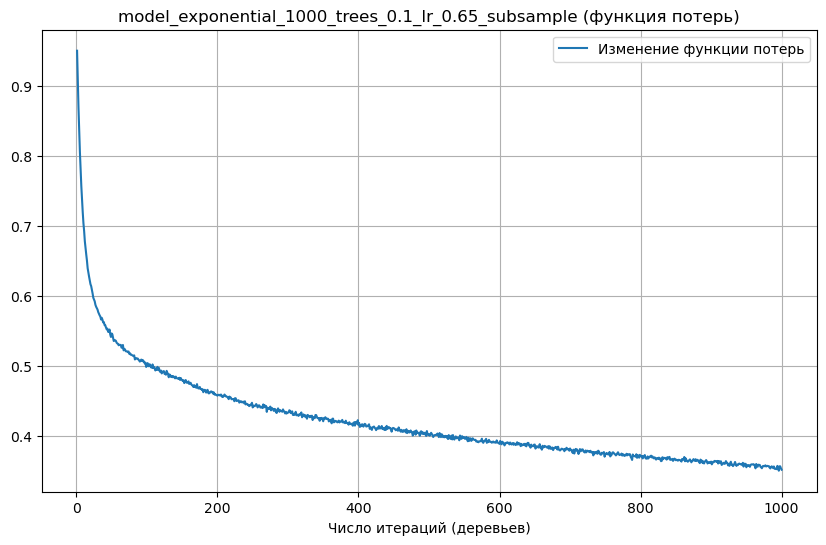

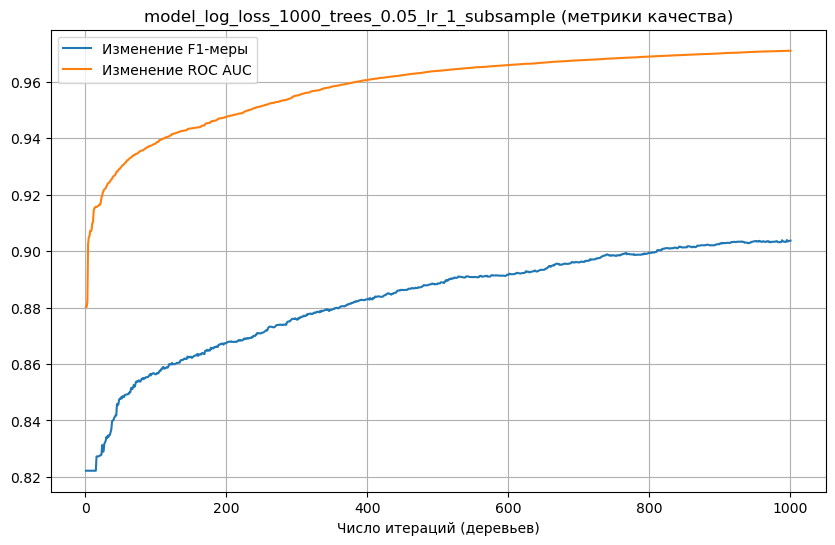

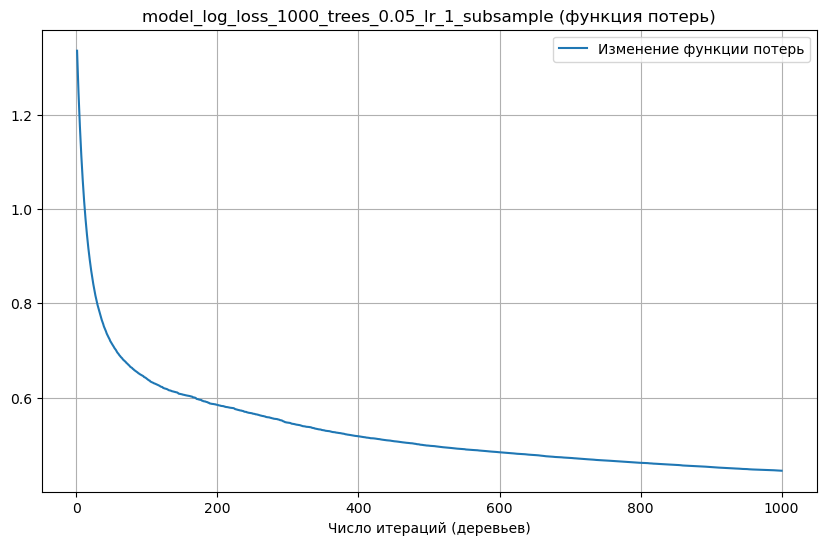

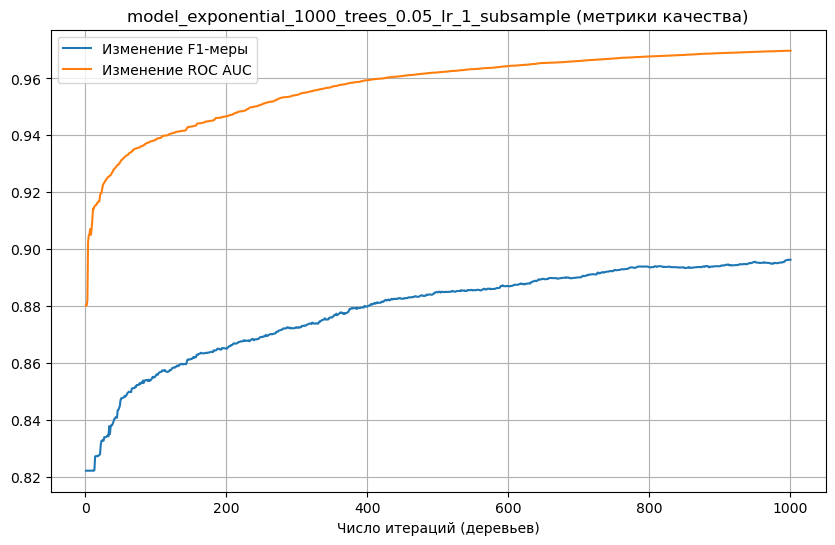

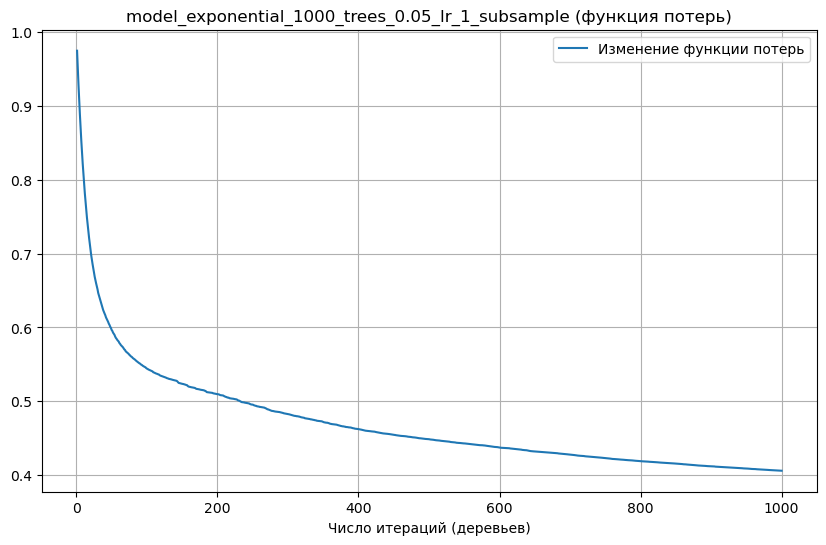

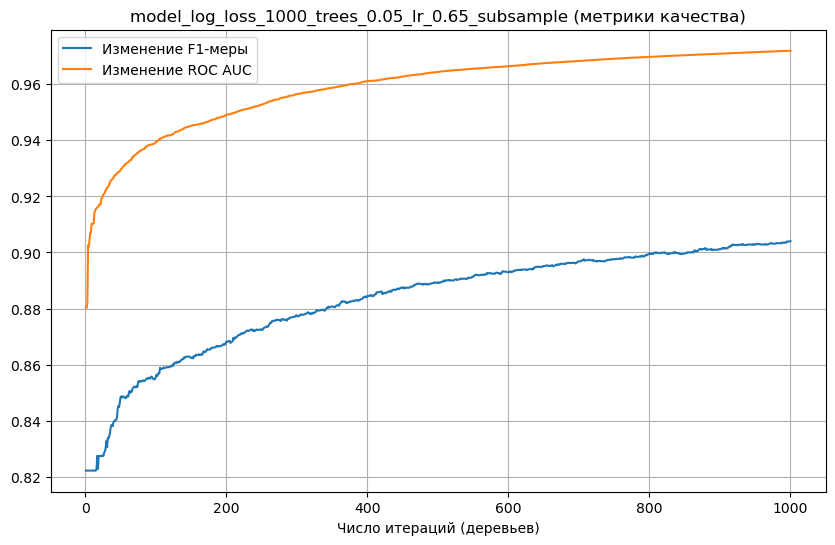

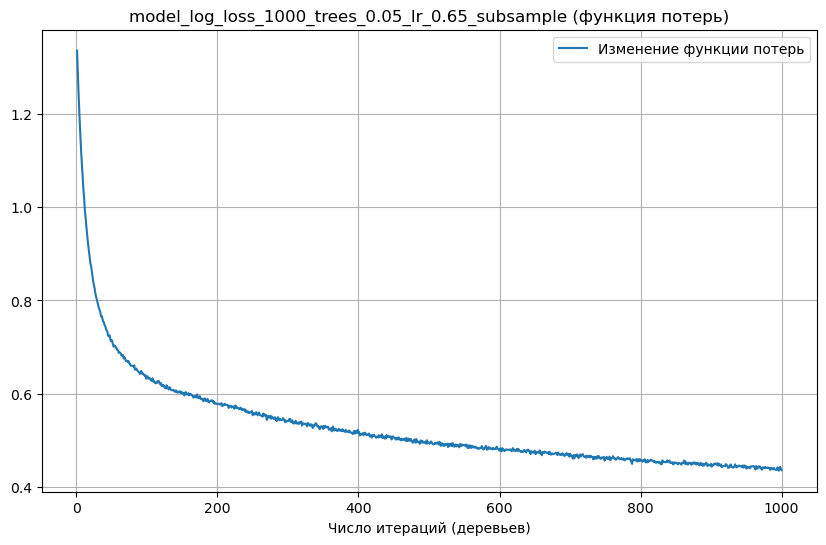

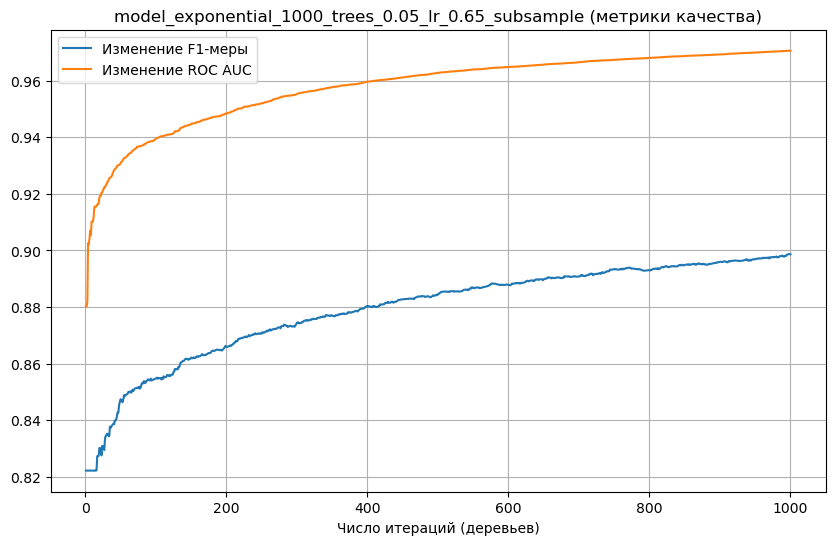

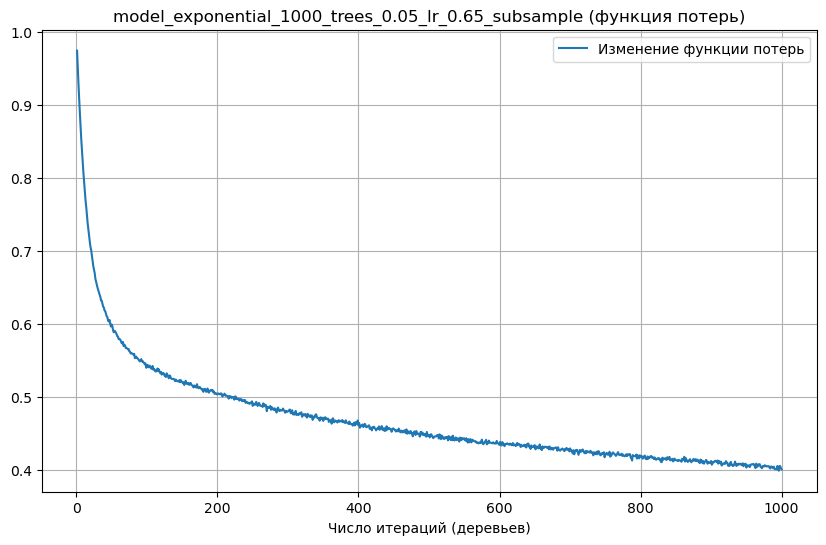

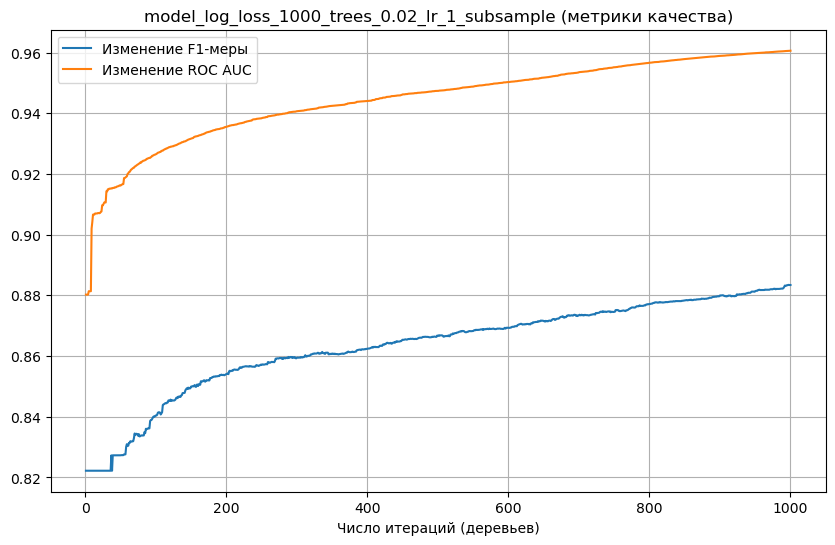

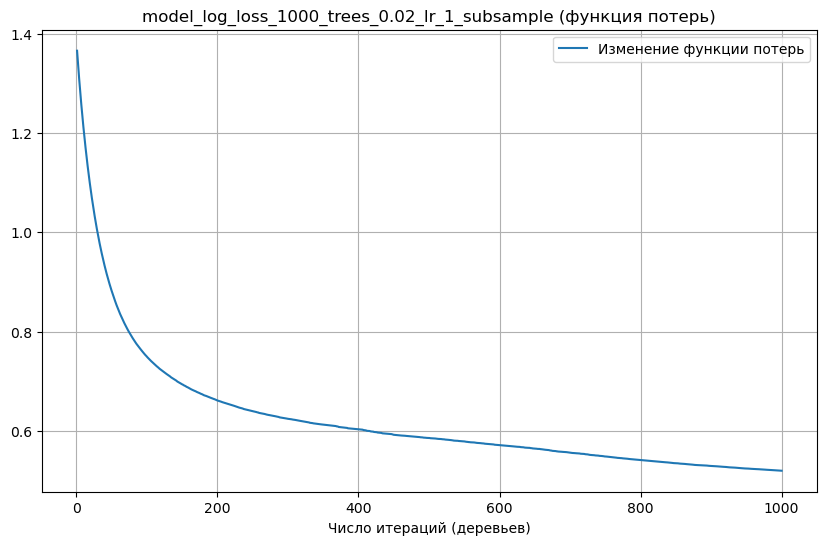

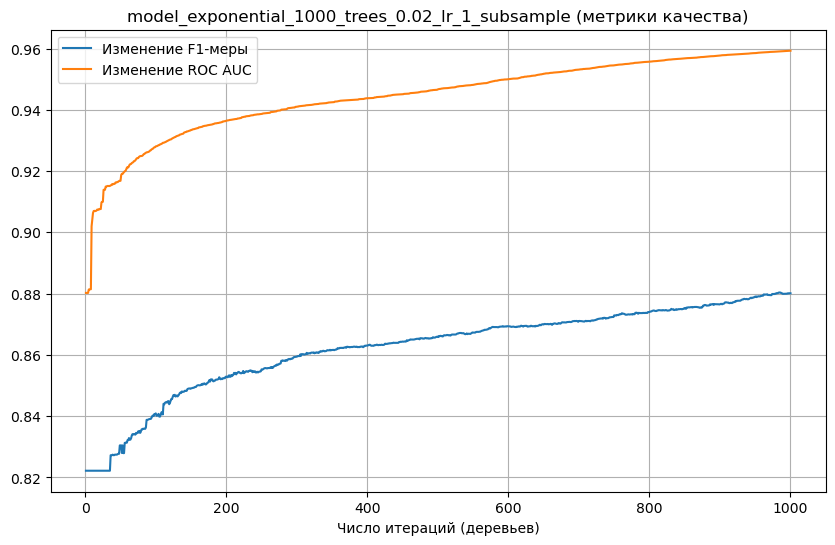

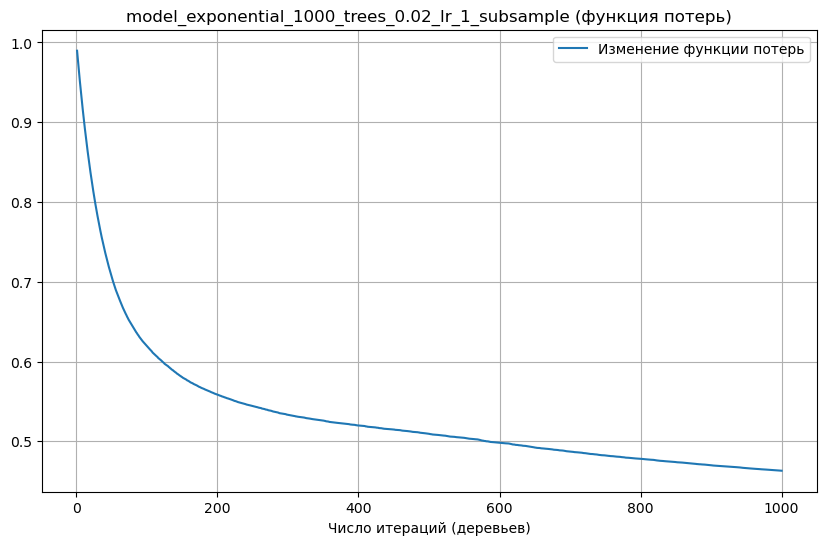

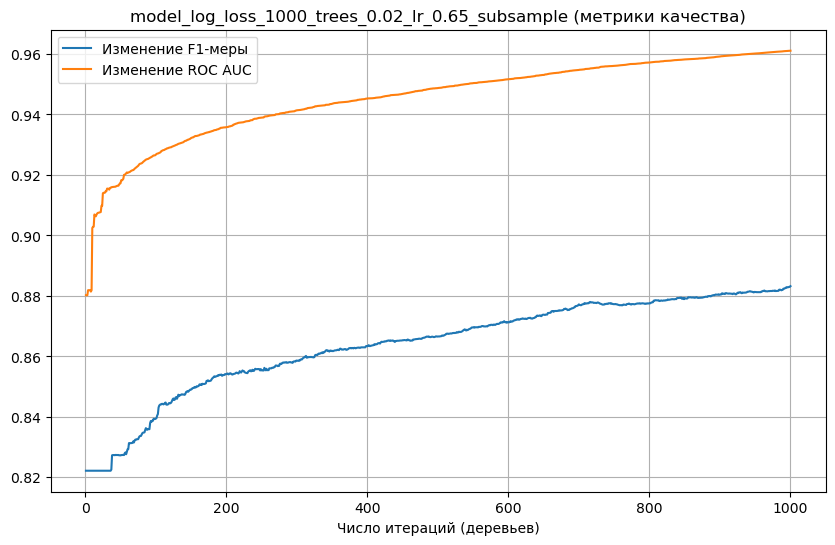

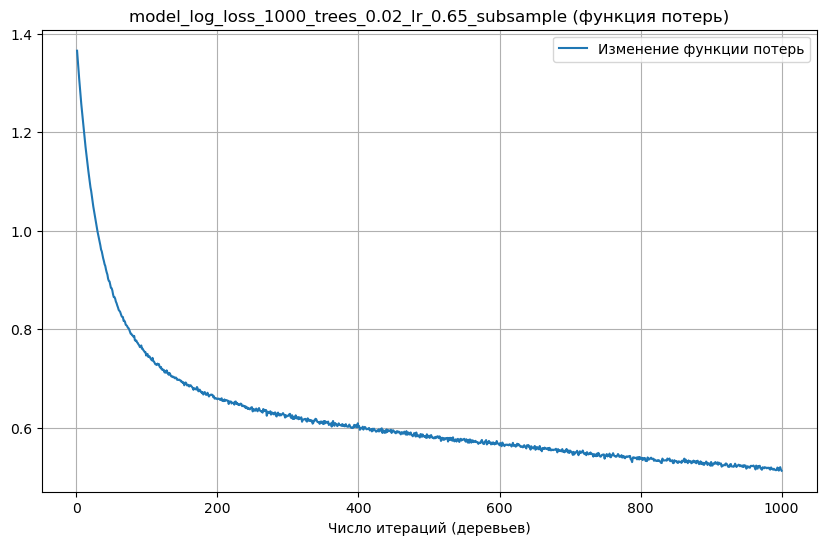

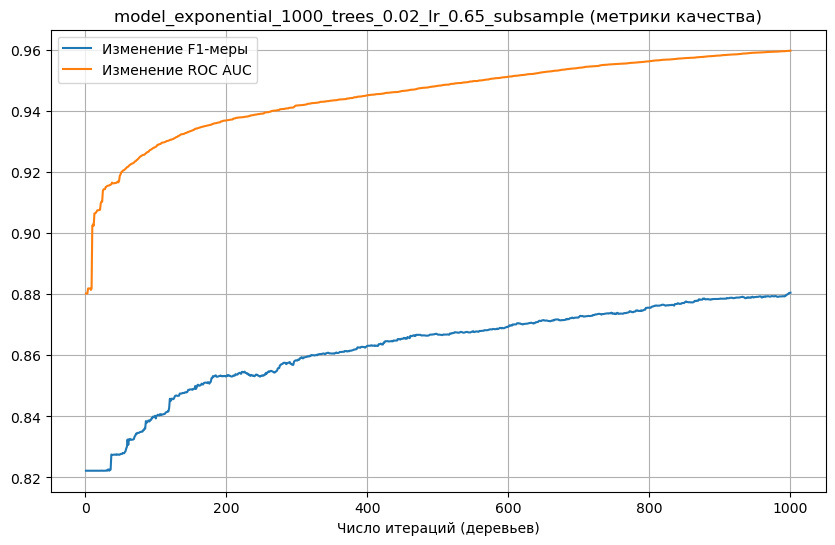

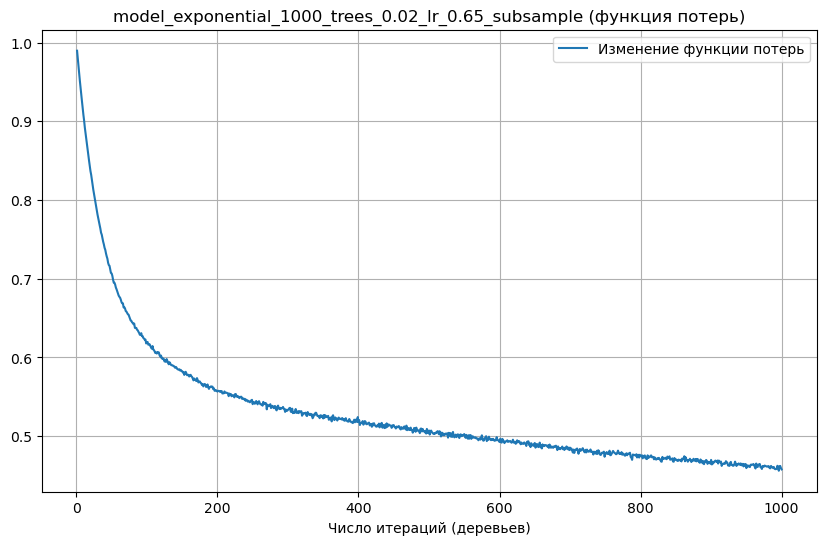

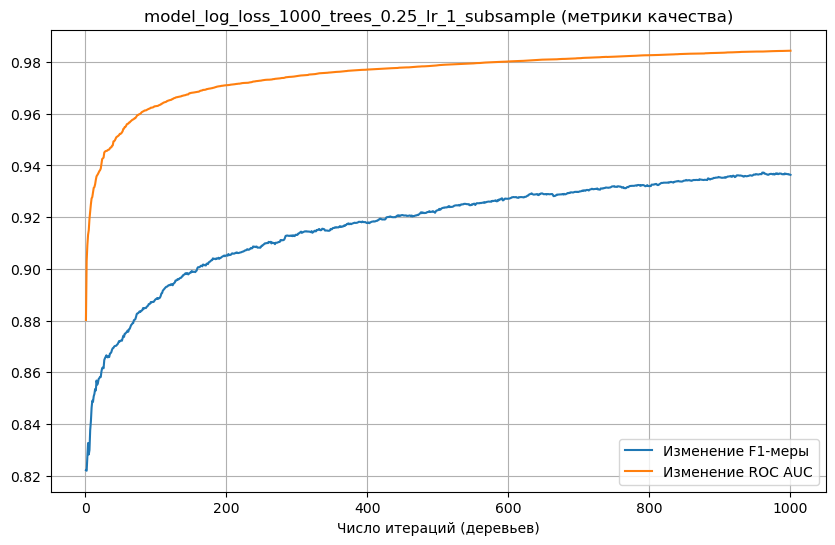

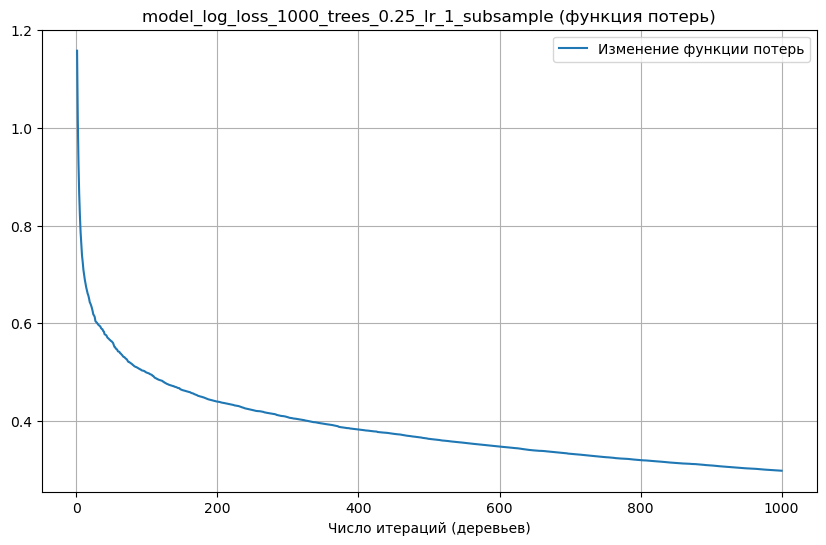

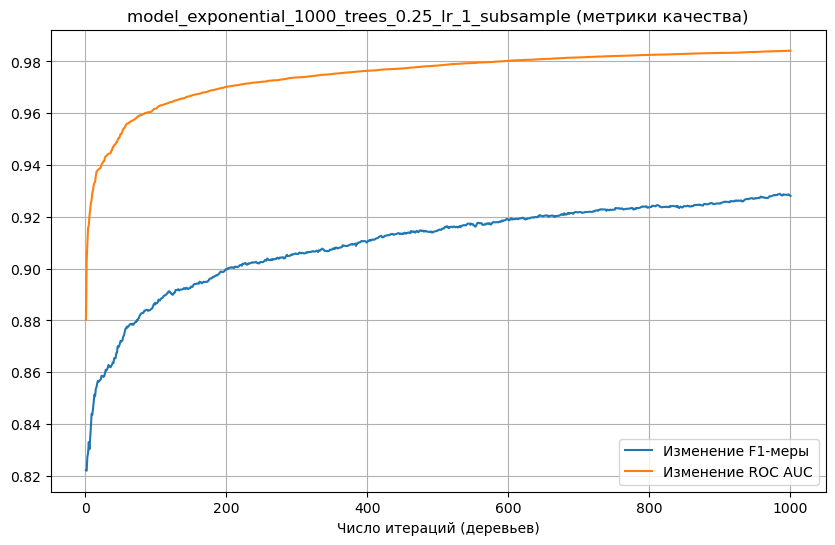

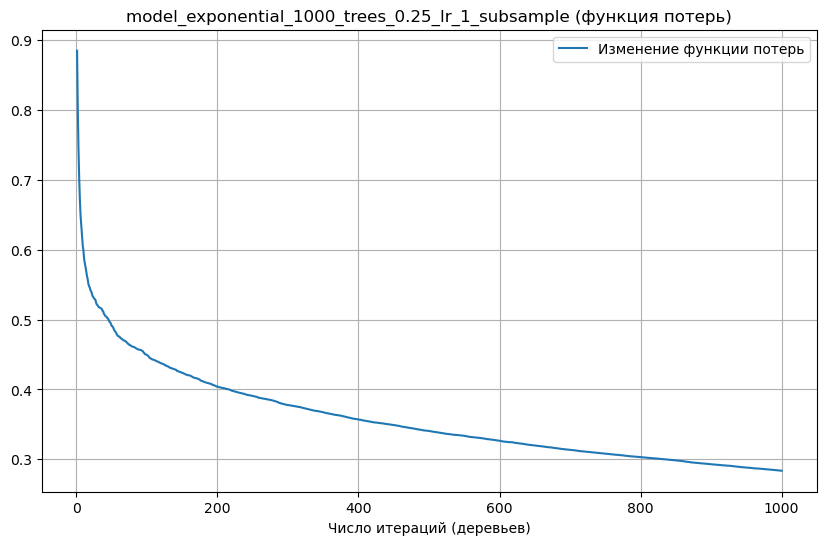

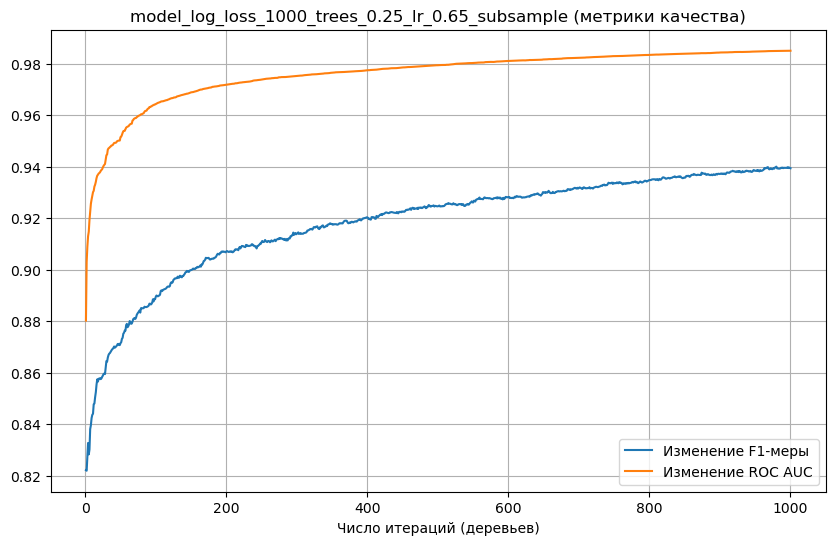

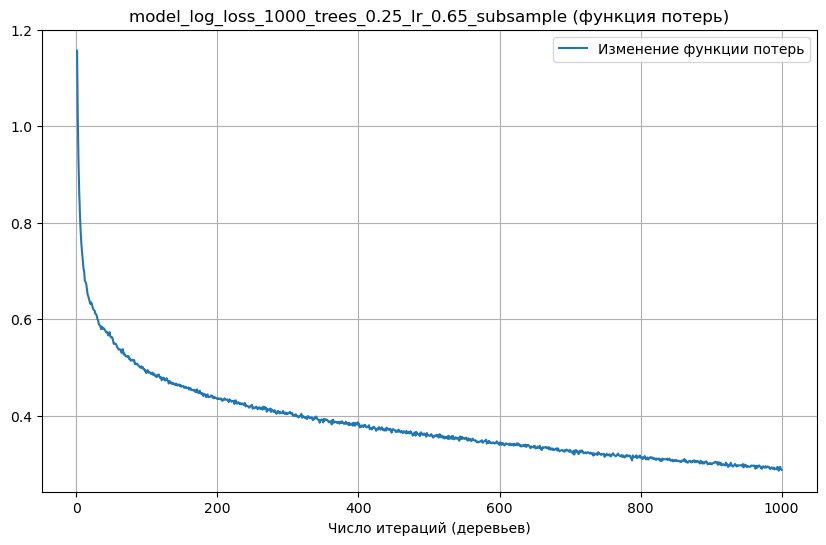

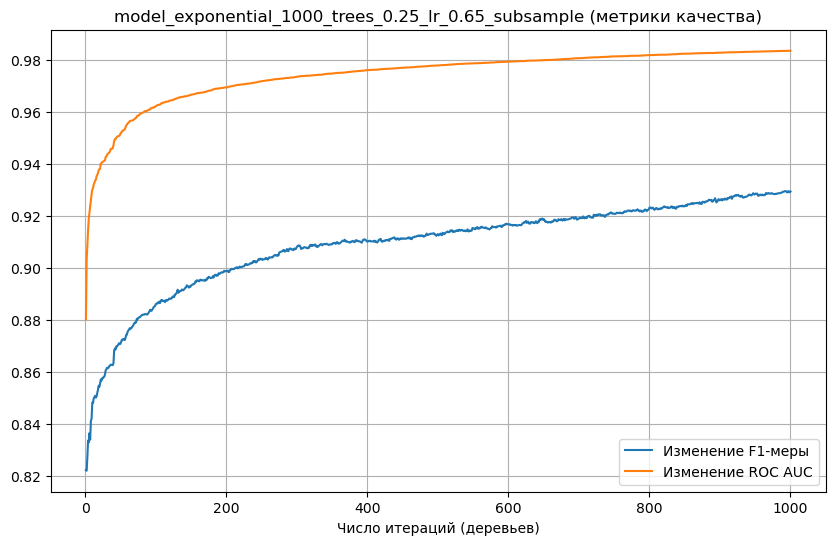

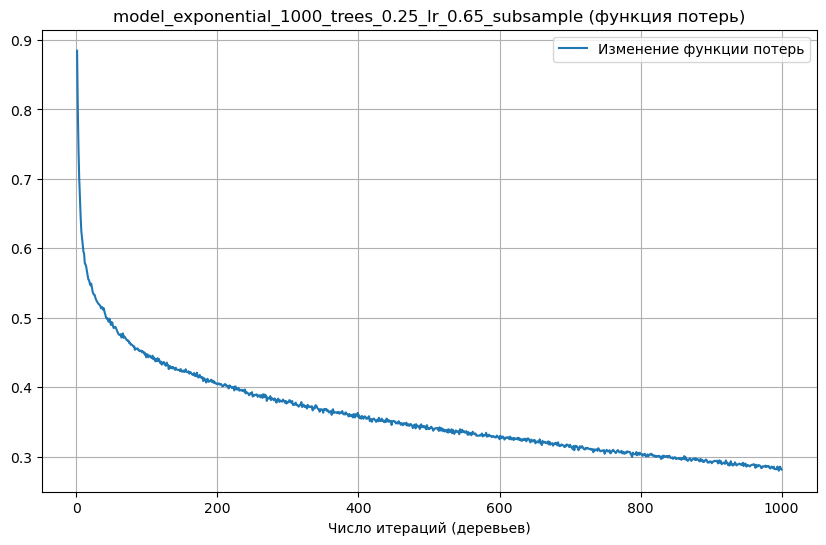

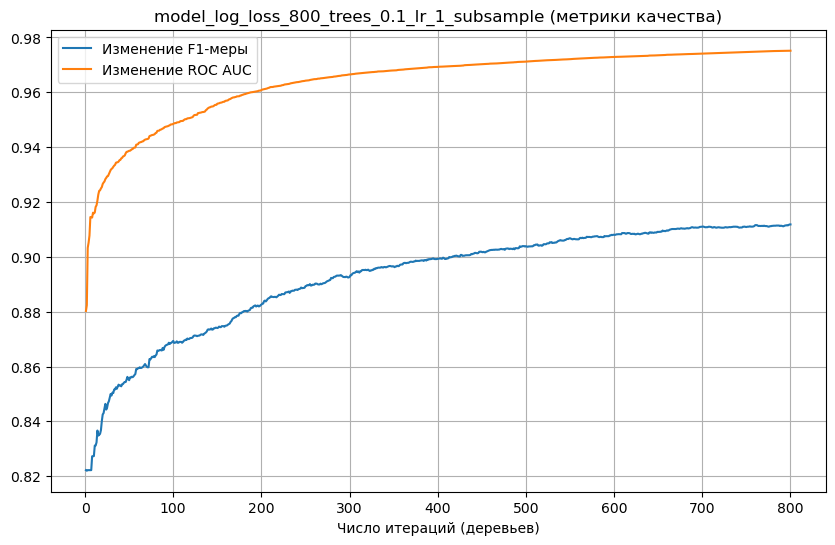

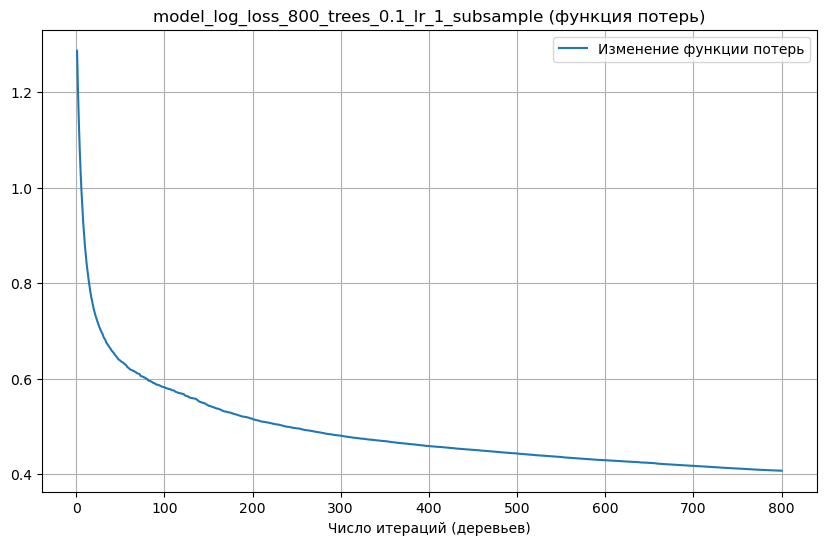

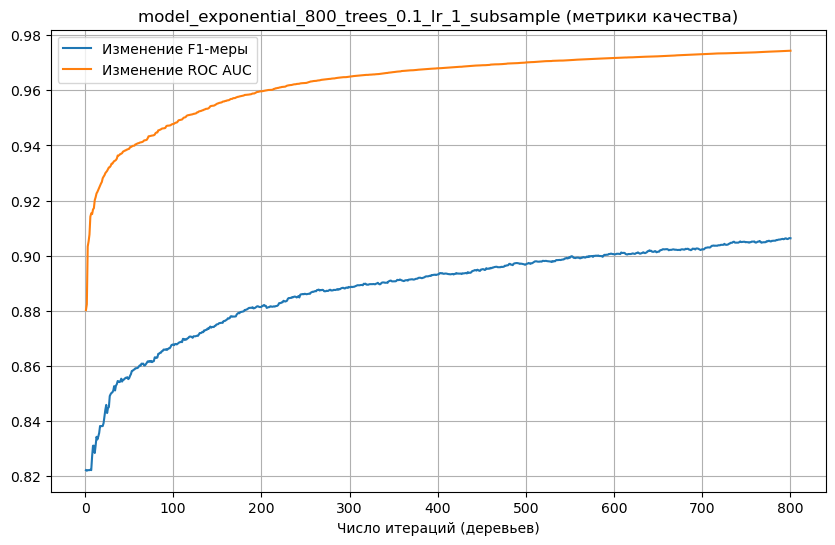

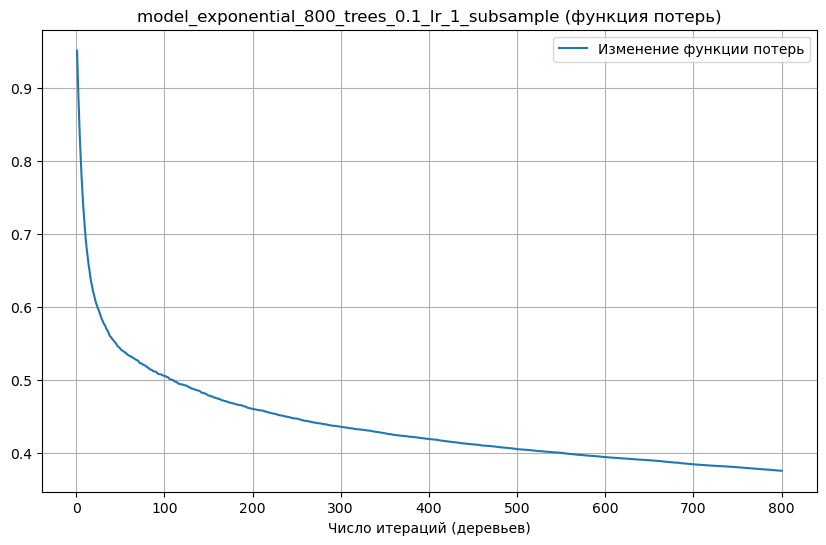

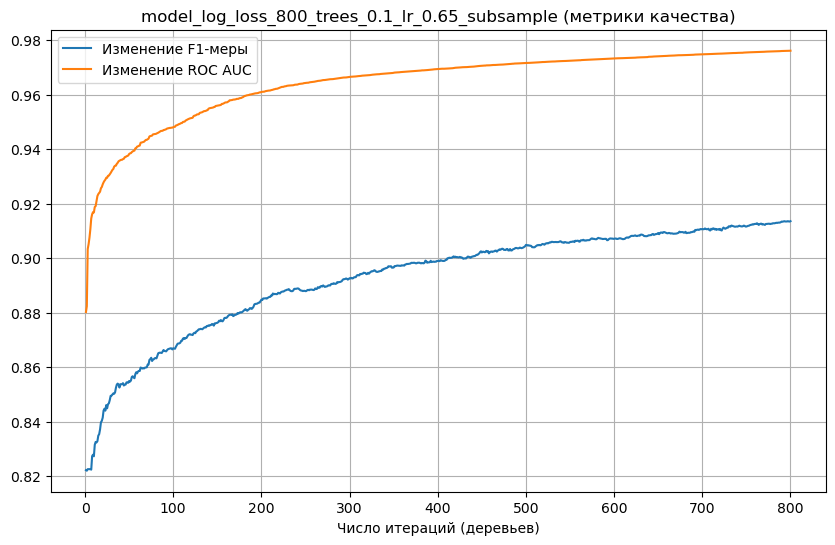

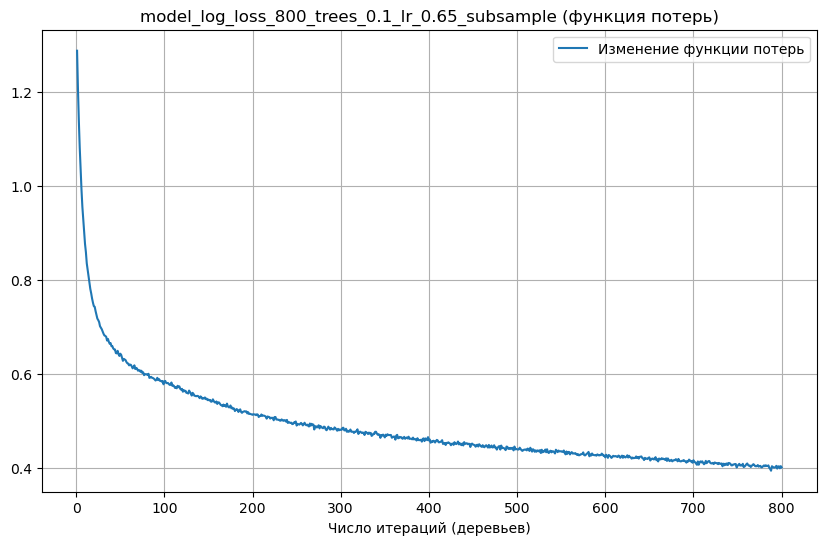

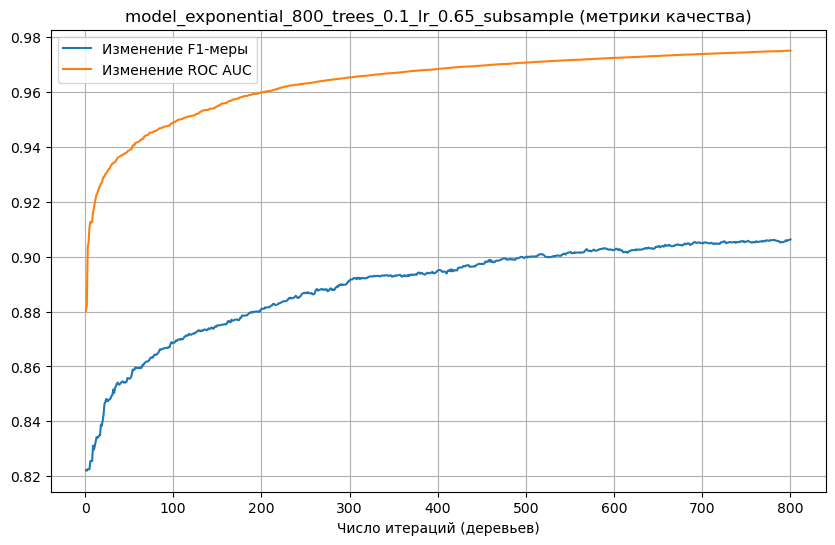

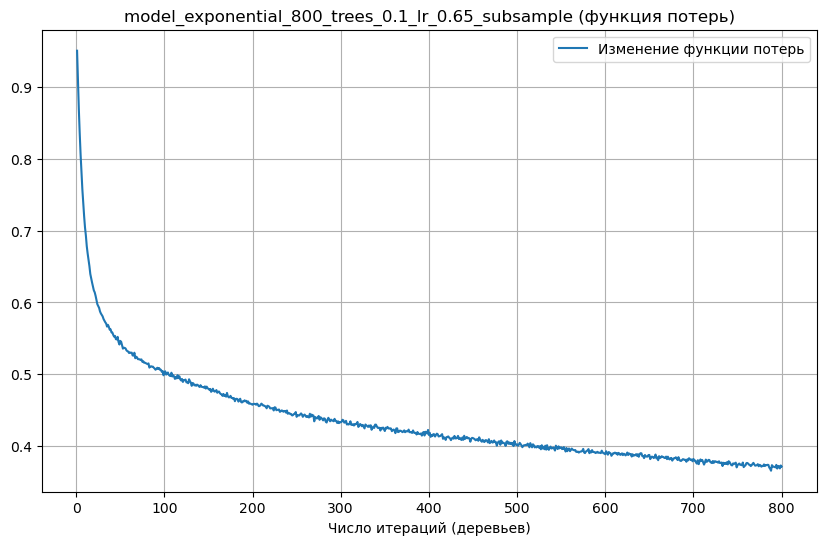

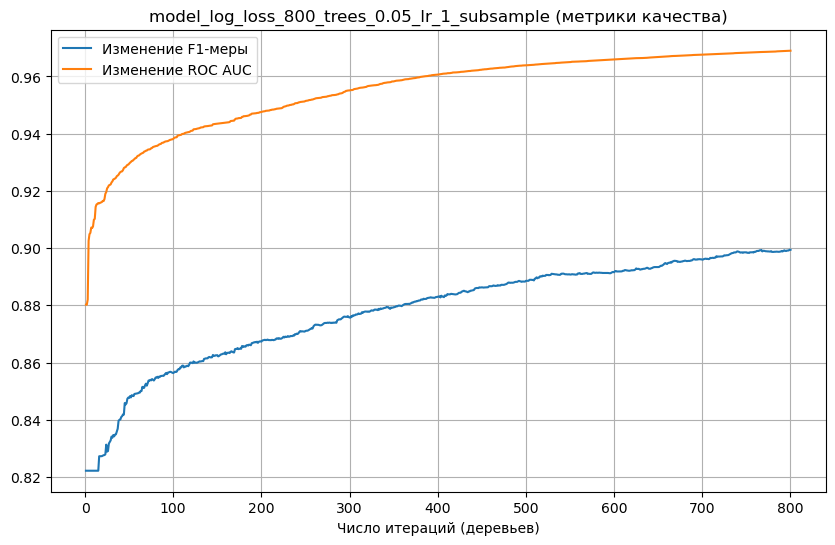

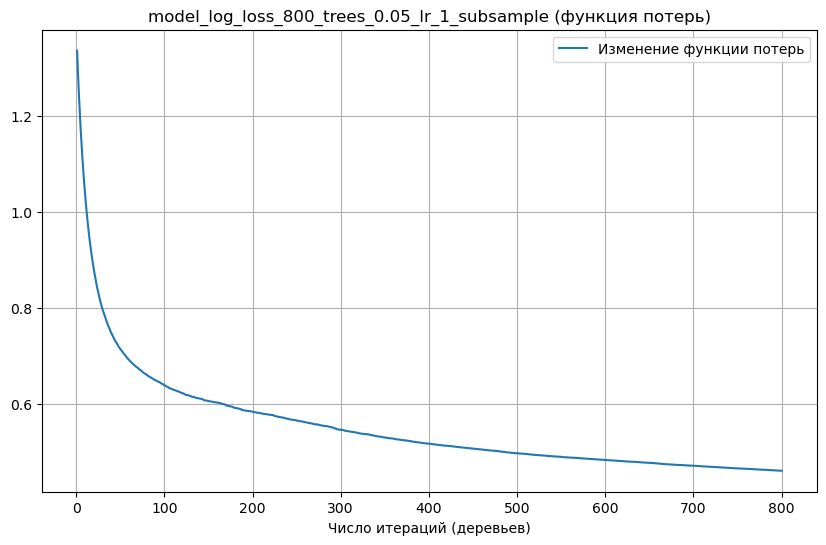

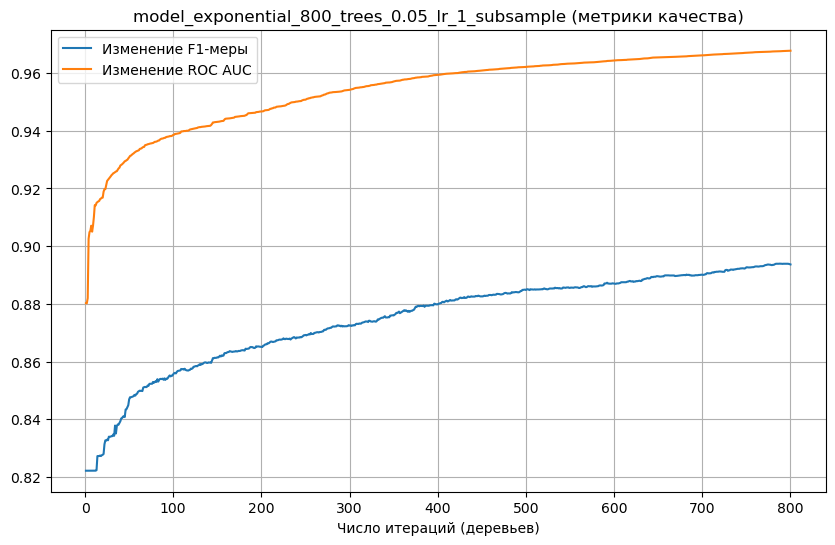

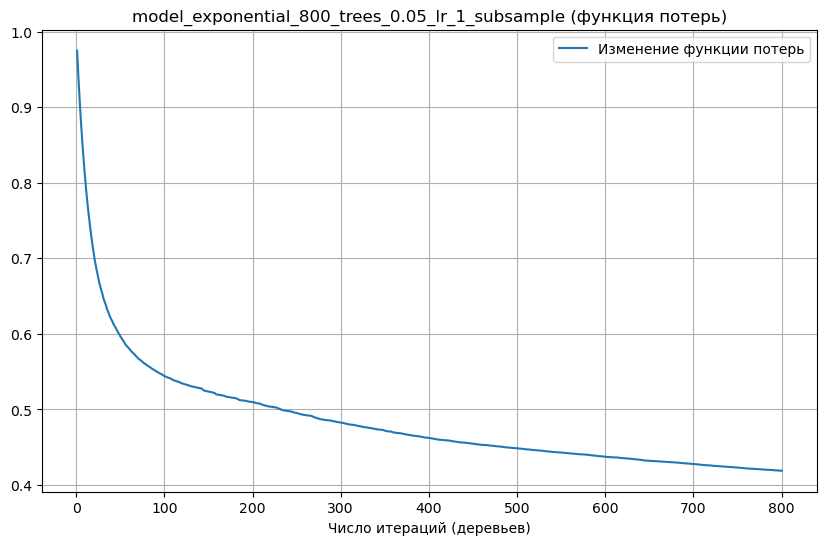

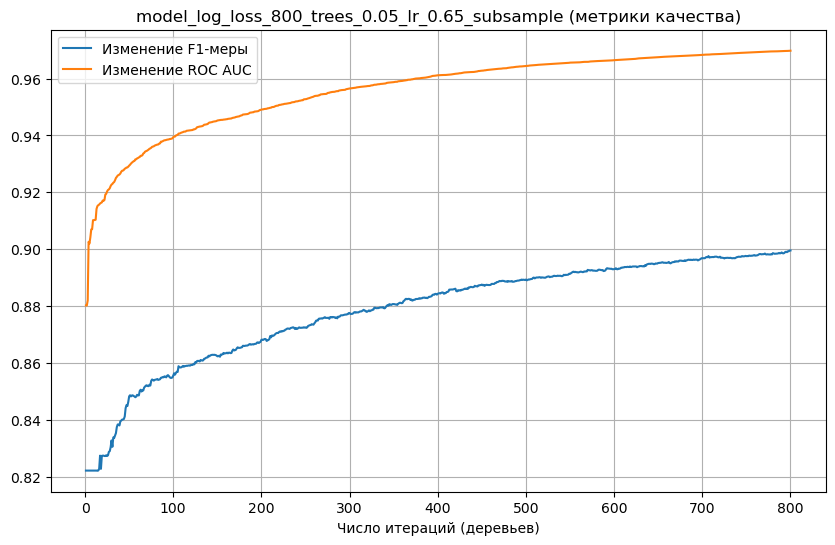

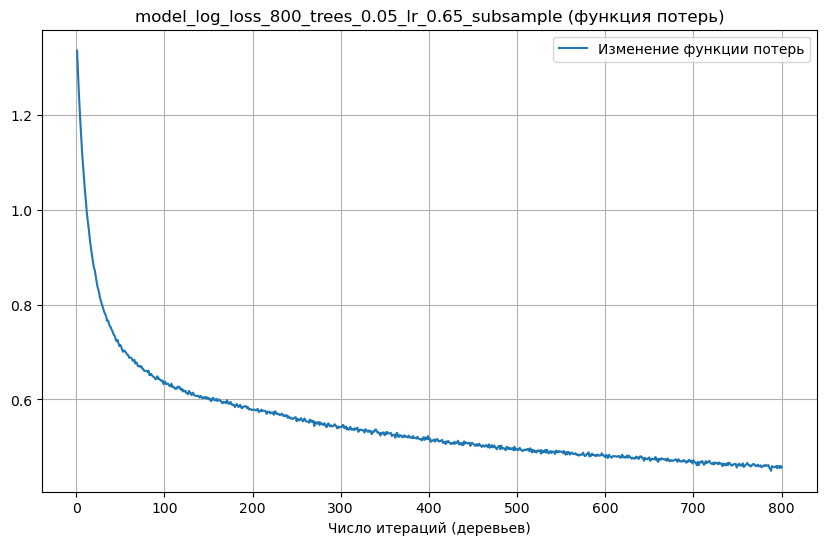

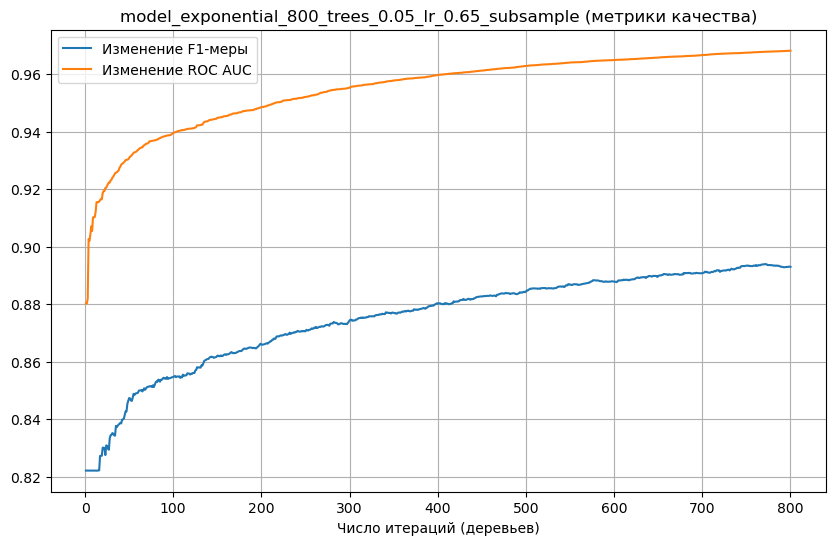

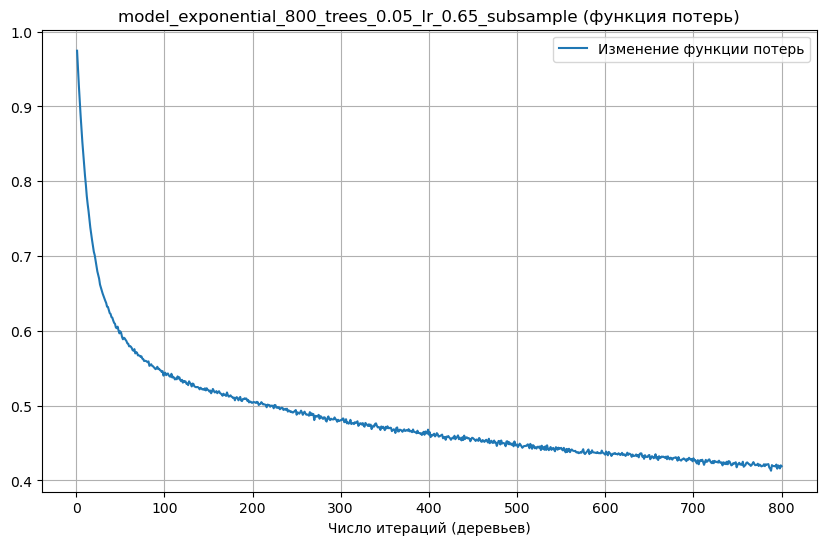

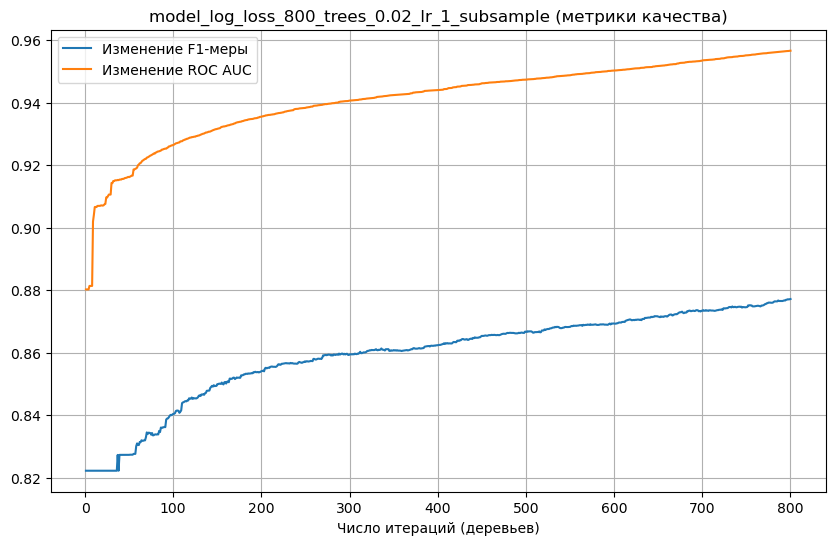

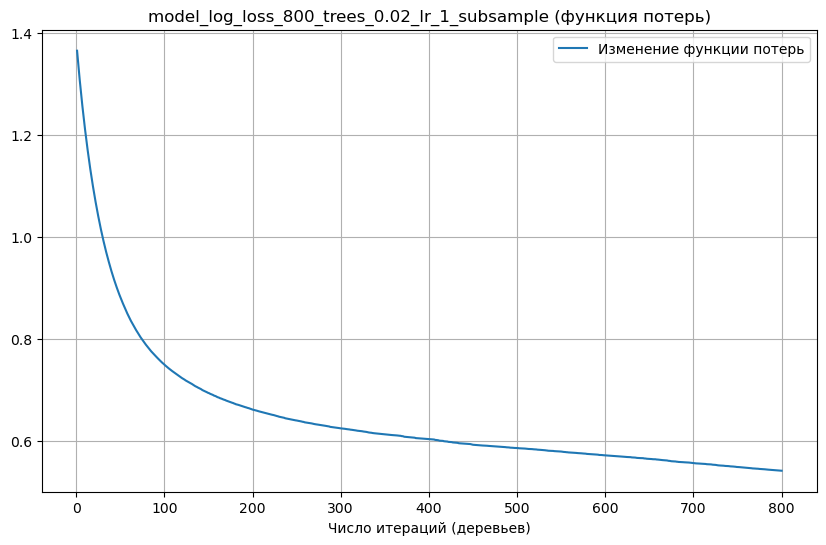

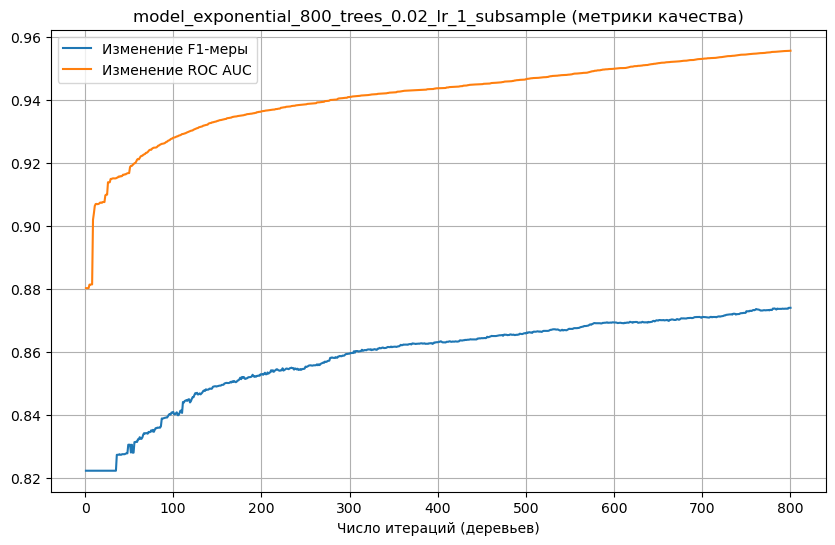

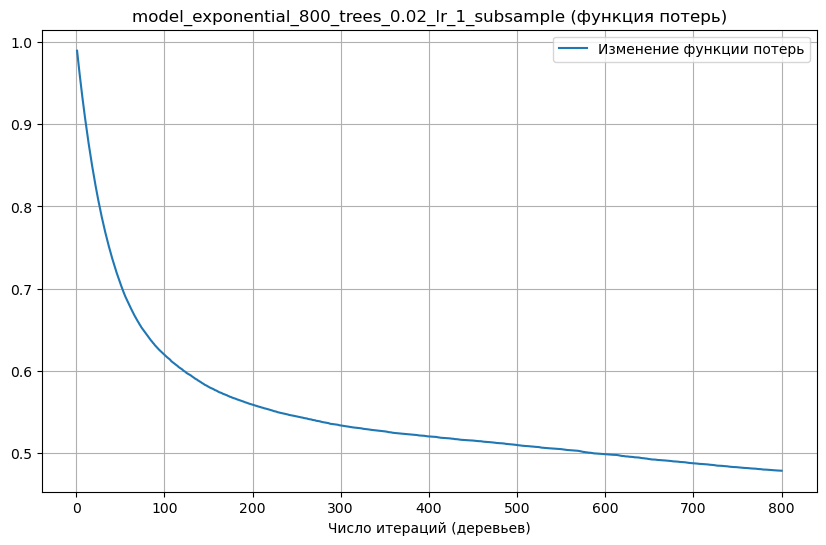

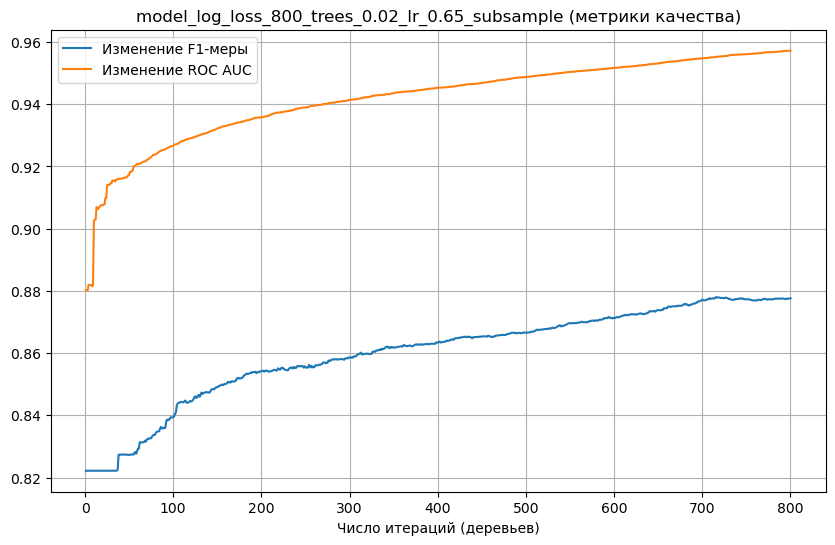

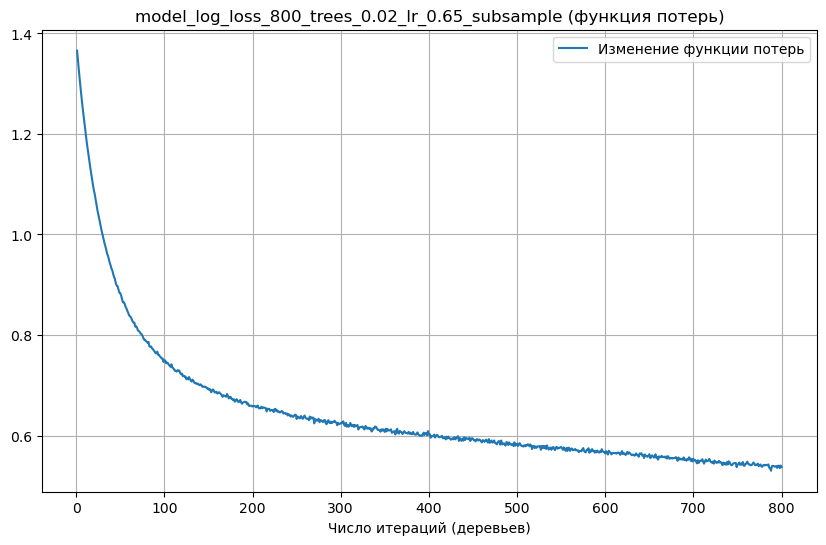

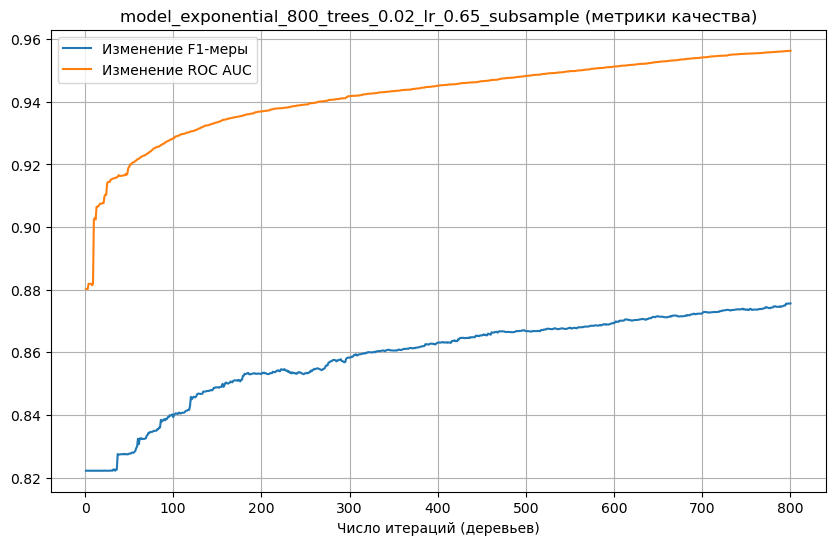

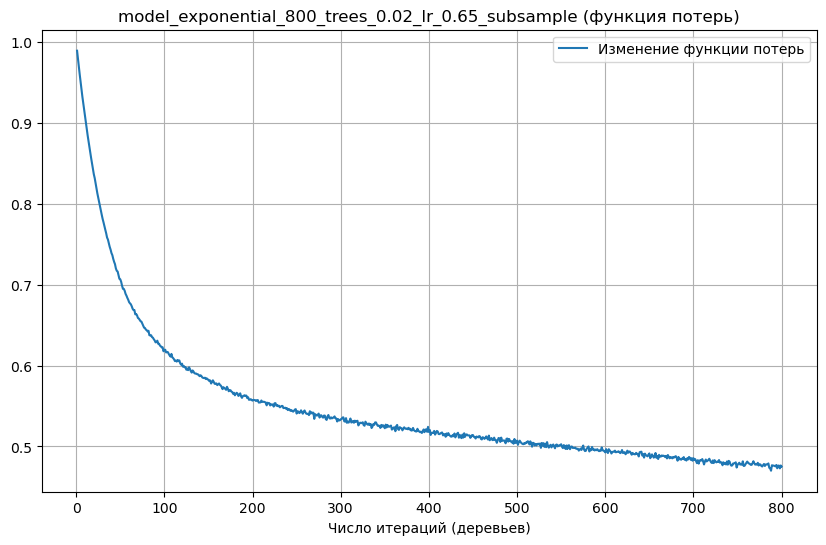

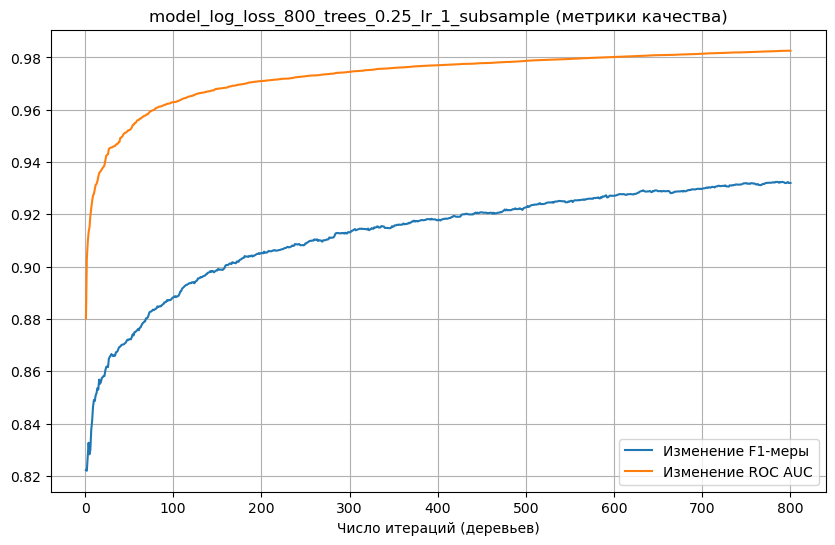

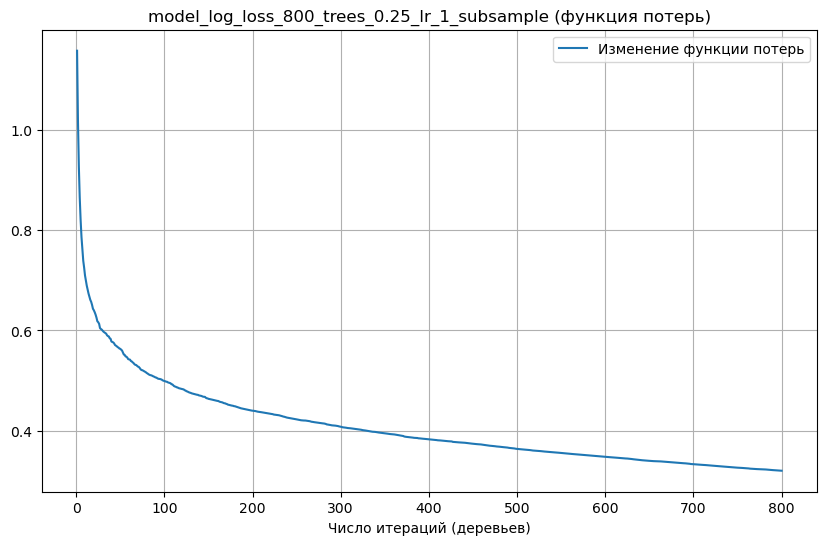

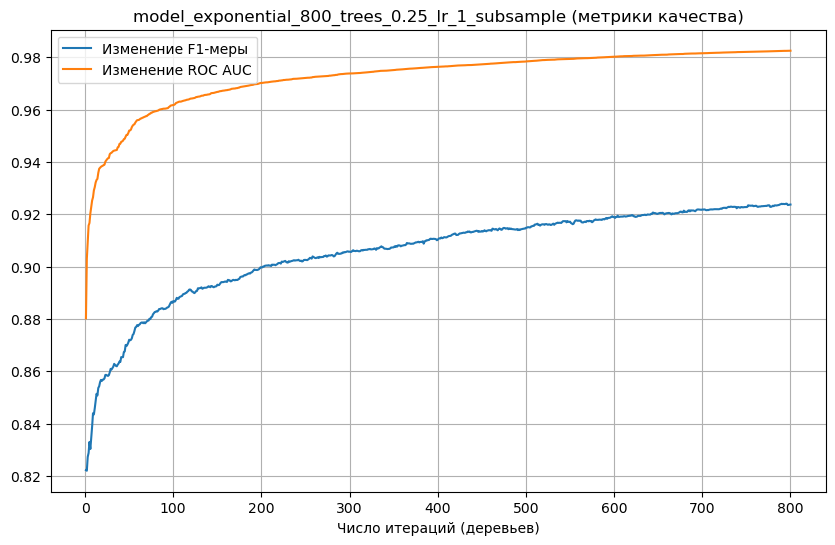

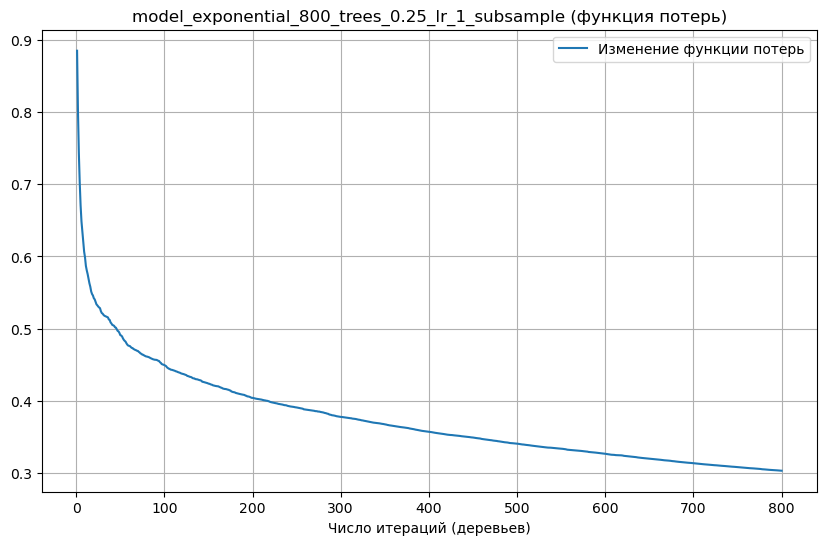

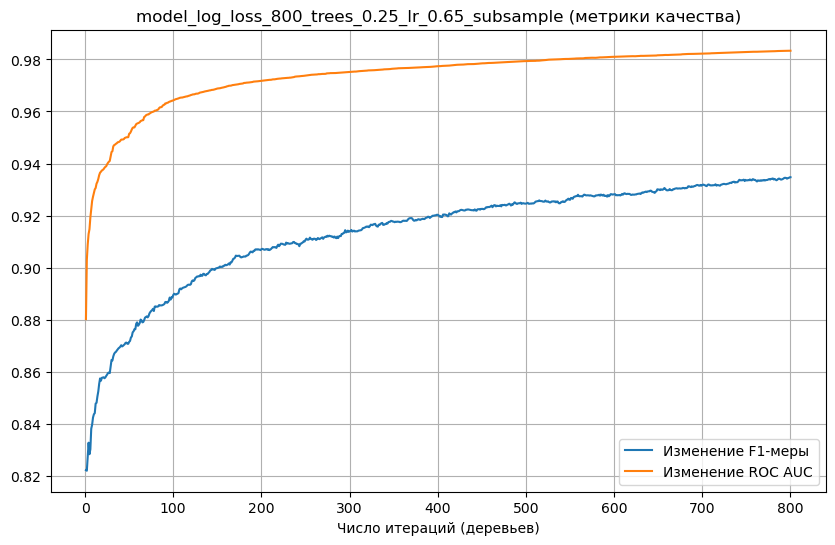

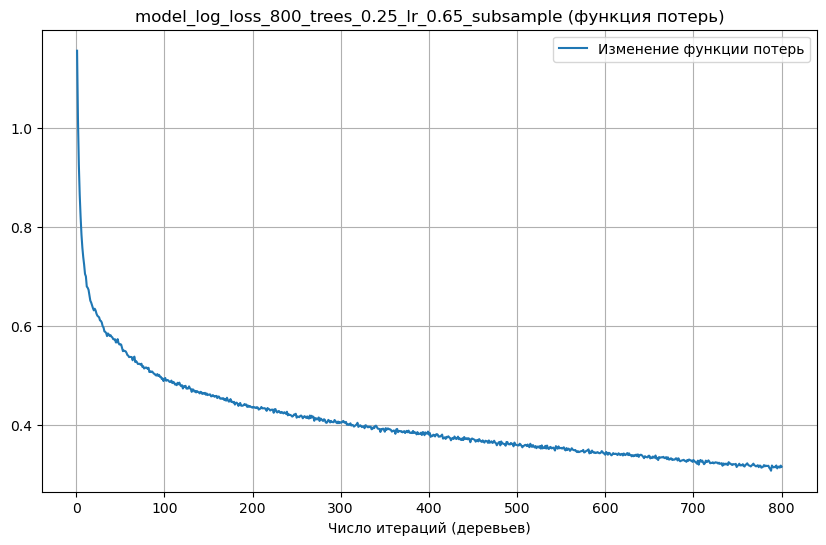

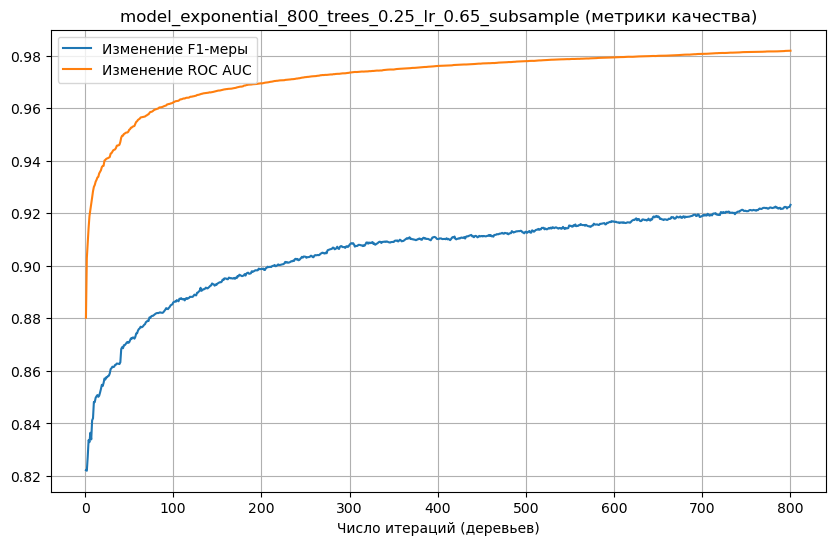

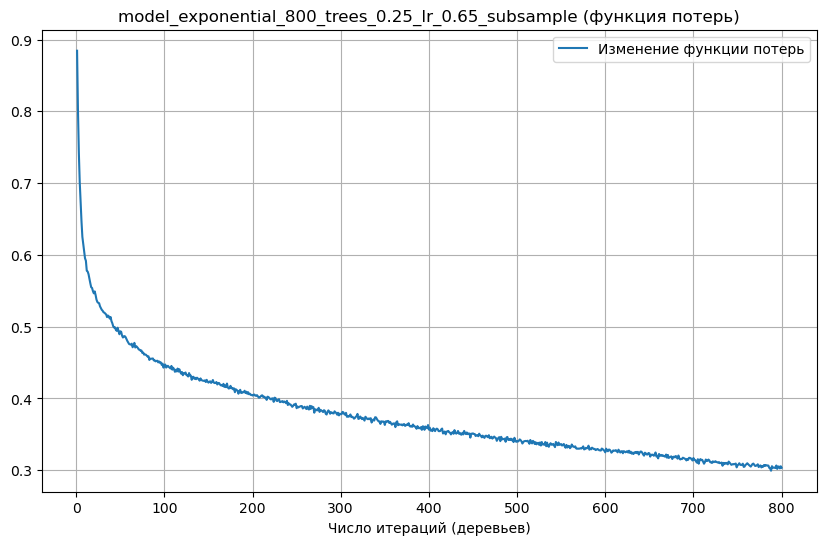

In [33]:
for model_info in training_report:
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(model_info.f1_score_history) + 1), model_info.f1_score_history, label="Изменение F1-меры")
    plt.plot(np.arange(1, len(model_info.roc_auc_history) + 1), model_info.roc_auc_history, label="Изменение ROC AUC")
    plt.xlabel("Число итераций (деревьев)")
    plt.title(f"{model_info.model_name} (метрики качества)")
    plt.legend()
    plt.grid()
   
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(model_info.loss_history) + 1), model_info.loss_history, label="Изменение функции потерь")
    plt.xlabel("Число итераций (деревьев)")
    plt.title(f"{model_info.model_name} (функция потерь)")
    plt.legend()
    plt.grid()
    plt.show()

Глобально по графикам можно заметить, что в самом начале обучения (маленькое число деревьев) наблюдается стремительное улучшение качества работы модели на тестовой выборке и падениие значения функции потерь. Далее, примерно после 100-200 итераций, скорость изменения графиков уменьшается и с увеличением числа итераций они приближаются к плато

Также можно заметить, что большинство графиков моделей с subsample равным 1 плавные, в то время как при sumbample равном 0.65 наблюдаются небольшие колебания примерно после 100-й итерации

Чем выше learning_rate модели, тем быстрее она доходит до состояния плато как по качеству прогнозов на тестовой выборке, так и по изменению функции потерь. Однако можно заметить, что ни на одном из графиков не наблюдалось полного плато, а значит гипотетическое увеличение размера модели может показать лучший результат

Выбор функции потерь изменяет историю обучения не так сильно, как остальные гиперпараметры, однако 

Выделим наилучший классификатор (показавший наибольший ROC AUC score на тестовой выборке) и проанализируем его

In [34]:
best_classifier.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.25,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 0.65,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Построим гистограмму влияния каждого из признаков на предсказанный ответ для лучшей модели

In [35]:
features = best_classifier.feature_names_in_
importances = best_classifier.feature_importances_

In [36]:
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
feature_importances_df

Feature  Importance
0                          person_age    0.012802
1                       person_income    0.153373
2                   person_emp_length    0.016741
3                           loan_amnt    0.018464
4                       loan_int_rate    0.079856
5                 loan_percent_income    0.330872
6          cb_person_cred_hist_length    0.005446
7      person_home_ownership_MORTGAGE    0.003088
8         person_home_ownership_OTHER    0.000525
9           person_home_ownership_OWN    0.014601
10         person_home_ownership_RENT    0.055529
11      loan_intent_DEBTCONSOLIDATION    0.009045
12              loan_intent_EDUCATION    0.004194
13        loan_intent_HOMEIMPROVEMENT    0.012542
14                loan_intent_MEDICAL    0.009025
15               loan_intent_PERSONAL    0.003428
16                loan_intent_VENTURE    0.008943
17                 loan_grade_encoded    0.260536
18  cb_person_default_on_file_encoded    0.000987

In [37]:
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

Feature  Importance
5                 loan_percent_income    0.330872
17                 loan_grade_encoded    0.260536
1                       person_income    0.153373
4                       loan_int_rate    0.079856
10         person_home_ownership_RENT    0.055529
3                           loan_amnt    0.018464
2                   person_emp_length    0.016741
9           person_home_ownership_OWN    0.014601
0                          person_age    0.012802
13        loan_intent_HOMEIMPROVEMENT    0.012542
11      loan_intent_DEBTCONSOLIDATION    0.009045
14                loan_intent_MEDICAL    0.009025
16                loan_intent_VENTURE    0.008943
6          cb_person_cred_hist_length    0.005446
12              loan_intent_EDUCATION    0.004194
15               loan_intent_PERSONAL    0.003428
7      person_home_ownership_MORTGAGE    0.003088
18  cb_person_default_on_file_encoded    0.000987
8         person_home_ownership_OTHER    0.000525

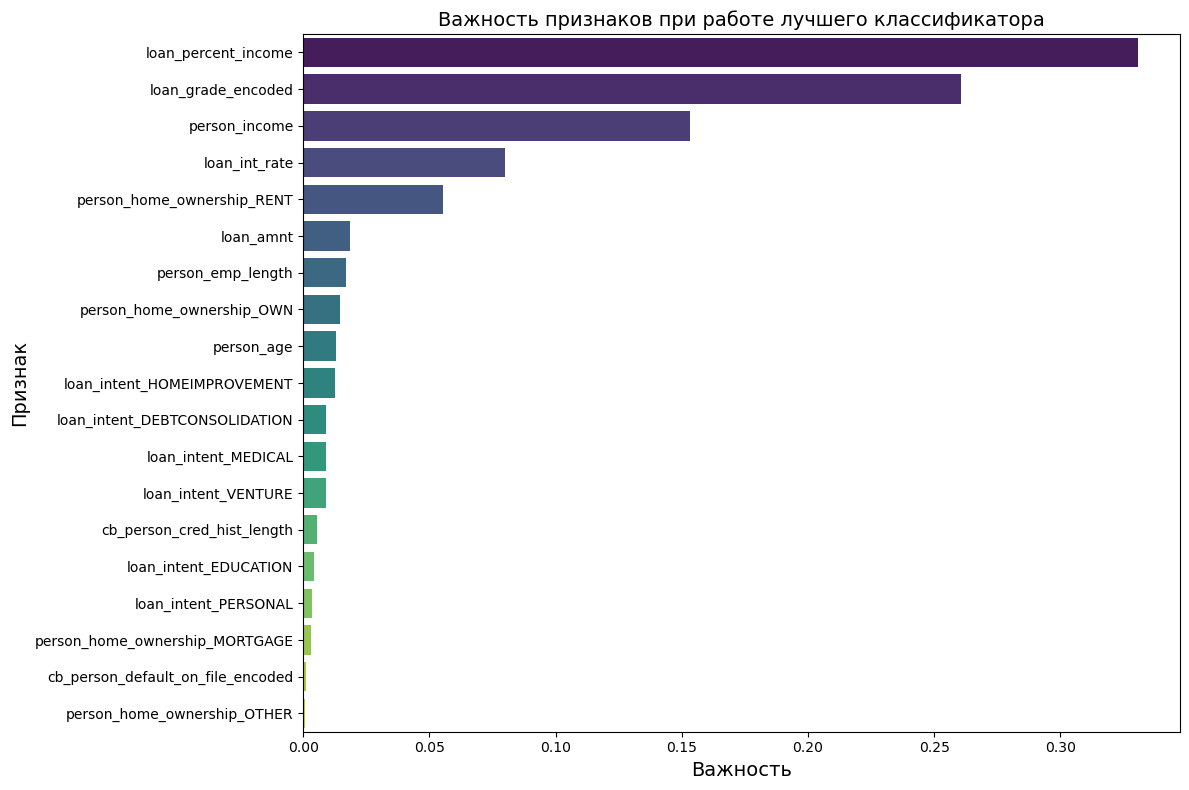

In [38]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')

plt.title('Важность признаков при работе лучшего классификатора', fontsize=14)
plt.xlabel('Важность', fontsize=14)
plt.ylabel('Признак', fontsize=14)

plt.tight_layout()
plt.show()

Наиболее важным оказалось отношение размера кредита к доходу заемщика (что логично, так как это комбинированная метрика), также важными являются категория риска кредита и непосредственный доход заемщика

Интересно, что исчезающе низкую оценку получило нахождение заемщика в базе данных кредитных дефолтов. Низкие оценки для цели кредита и владения недвижимостью можно объяснить разбиением этих признаков на dummy-столбцы

## Прогноз на тестовых данных

Загрузим тестовый датасет и предобработаем его так же, как и тренировочные данные

In [39]:
test_df = pd.read_csv(f"{data_path}/test.csv", index_col=0)
test_df.sample(10)

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                          
97649          22          54400                  RENT                2.0   
92000          44          80000              MORTGAGE                2.0   
97253          24         122000                  RENT                1.0   
73801          31          40000              MORTGAGE                3.0   
74695          24          65000              MORTGAGE                8.0   
62651          27          34000                   OWN                3.0   
58793          24          53000                  RENT                3.0   
59678          22          48000              MORTGAGE                4.0   
82865          26          83300                  RENT                0.0   
80001          28          85000                  RENT                2.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
id                                                              
97649            MEDICAL          B       5000          11.86   
92000  DEBTCONSOLIDATION          B      12600          10.25   
97253            MEDICAL          C      15000          13.47   
73801            MEDICAL          A       8000           8.59   
74695            MEDICAL          A       5000           7.88   
62651    HOMEIMPROVEMENT          C      12800          12.99   
58793          EDUCATION          C      12800          13.16   
59678            MEDICAL          A       5000           5.42   
82865            MEDICAL          D      28000          16.77   
80001            VENTURE          B       6000          11.89   

       loan_percent_income cb_person_default_on_file  \
id                                                     
97649                 0.08                         N   
92000                 0.16                         N   
97253                 0.12                         N   
73801                 0.20                         N   
74695                 0.08                         N   
62651                 0.42                         Y   
58793                 0.24                         Y   
59678                 0.10                         N   
82865                 0.29                         Y   
80001                 0.07                         N   

       cb_person_cred_hist_length  
id                                 
97649                           2  
92000                          12  
97253                           3  
73801                           6  
74695                           4  
62651                           9  
58793                           4  
59678                           4  
82865                           2  
80001                           8

In [40]:
test_df.shape

(39098, 11)

In [41]:
test_df = pd.get_dummies(test_df, columns=one_hot_columns, drop_first=False)
test_df.sample(10)

person_age  person_income  person_emp_length loan_grade  loan_amnt  \
id                                                                          
96541          21          75000                5.0          A       6000   
62070          26          36000                0.0          D       6400   
77955          31          41004                5.0          B       3000   
66072          30         105500                1.0          D       6000   
72514          25          24000                2.0          B       1200   
78023          22          85000                7.0          C      35000   
67511          30          47300                5.0          B      14000   
96330          25          36000                0.0          A       5000   
79618          27         110000                0.0          B       6000   
69220          24          70500                8.0          C       9600   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
id                                                                    
96541           5.79                 0.08                         N   
62070          15.65                 0.18                         N   
77955          11.14                 0.07                         N   
66072          15.70                 0.06                         N   
72514          12.42                 0.05                         N   
78023          13.80                 0.41                         N   
67511          12.42                 0.30                         N   
96330           7.88                 0.14                         N   
79618          12.53                 0.05                         N   
69220          12.73                 0.14                         N   

       cb_person_cred_hist_length  person_home_ownership_MORTGAGE  \
id                                                                  
96541                           3                            True   
62070                           4                           False   
77955                           9                           False   
66072                           9                           False   
72514                           2                           False   
78023                           4                           False   
67511                           9                            True   
96330                           4                           False   
79618                           7                           False   
69220                           2                            True   

       person_home_ownership_OTHER  person_home_ownership_OWN  \
id                                                              
96541                        False                      False   
62070                        False                       True   
77955                        False                      False   
66072                        False                      False   
72514                        False                      False   
78023                        False                      False   
67511                        False                      False   
96330                        False                      False   
79618                        False                      False   
69220                        False                      False   

       person_home_ownership_RENT  loan_intent_DEBTCONSOLIDATION  \
id                                                                 
96541                       False                          False   
62070                       False                          False   
77955                        True                           True   
66072                        True                          False   
72514                        True                           True   
78023                        True                          False   
67511                       False                          False   
96330  

In [42]:
test_df['loan_grade_encoded'] = ordinal_encoder.fit_transform(test_df[['loan_grade']])
test_df = test_df.drop('loan_grade', axis=1)
test_df.sample(10)

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
id                                                                              
78650          25          95000                0.0      25000          15.33   
60518          30          35000                0.0       5000          11.89   
73456          23          70000                0.0       3000           5.42   
90929          23          38500                2.0       5000           7.88   
86090          30          60000               12.0       3000           6.62   
97709          30          43200                6.0       8700          15.58   
59359          36          90000                2.0       8000          13.49   
78459          32          75250                0.0       6000           8.94   
92009          27          50000               11.0      12000           7.90   
78518          37          49000               15.0       4000          12.99   

       loan_percent_income cb_person_default_on_file  \
id                                                     
78650                 0.26                         Y   
60518                 0.14                         N   
73456                 0.04                         N   
90929                 0.13                         N   
86090                 0.05                         N   
97709                 0.20                         Y   
59359                 0.09                         Y   
78459                 0.08                         N   
92009                 0.24                         N   
78518                 0.08                         Y   

       cb_person_cred_hist_length  person_home_ownership_MORTGAGE  \
id                                                                  
78650                           2                            True   
60518                           7                           False   
73456                           4                            True   
90929                           2                           False   
86090                           7                            True   
97709                           7                           False   
59359                          14                           False   
78459                           9                           False   
92009                           9                            True   
78518                          11                           False   

       person_home_ownership_OTHER  person_home_ownership_OWN  \
id                                                              
78650                        False                      False   
60518                        False                      False   
73456                        False                      False   
90929                        False                      False   
86090                        False                      False   
97709                        False                       True   
59359                        False                      False   
78459                        False                      False   
92009                        False                      False   
78518                        False                      False   

       person_home_ownership_RENT  loan_intent_DEBTCONSOLIDATION  \
id                                                                 
78650                       False                          False   
60518                        True                          False   
73456                       False                          False   
90929                        True                          False   
86090                       False                          False   
97709                       False                          False   
59359                        True                          False   
78459                        True                           True   
92009                       False                           True   
785

In [43]:
test_df['cb_person_default_on_file_encoded'] = test_df['cb_person_default_on_file'].map({'N': False, 'Y': True})
test_df = test_df.drop('cb_person_default_on_file', axis=1)
test_df.sample(10)

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
id                                                                              
96831          23          60000                6.0       7400          13.22   
63820          24          69996                1.0      14000          10.37   
78422          29          30000                3.0      10000          11.14   
68875          27          60000                3.0       4000          11.49   
60304          27          50000                2.0      10000          11.36   
69889          29          54000                1.0       6000           9.63   
88364          26         120000                5.0       5000          13.06   
78550          26          60000                1.0      21000          14.09   
91618          25          50000                9.0       6000          11.36   
92066          27          90000                2.0      15000          12.42   

       loan_percent_income  cb_person_cred_hist_length  \
id                                                       
96831                 0.13                           2   
63820                 0.20                           4   
78422                 0.33                           9   
68875                 0.07                           5   
60304                 0.20                           7   
69889                 0.11                           8   
88364                 0.04                           2   
78550                 0.35                           3   
91618                 0.12                           2   
92066                 0.17                           7   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
id                                                                   
96831                            True                        False   
63820                           False                        False   
78422                            True                        False   
68875                           False                        False   
60304                           False                        False   
69889                           False                        False   
88364                           False                        False   
78550                           False                        False   
91618                           False                        False   
92066                            True                        False   

       person_home_ownership_OWN  person_home_ownership_RENT  \
id                                                             
96831                      False                       False   
63820                      False                        True   
78422                      False                       False   
68875                      False                        True   
60304                       True                       False   
69889                      False                        True   
88364                      False                        True   
78550                       True                       False   
91618                      False                        True   
92066                      False                       False   

       loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
id                                                            
96831                          False                   True   
63820                          False                  False   
78422                          False                  False   
68875                          False                  False   
60304                          False                  False   
69889                           True                  False   
88364                          False                  False   
78550                          False                  False   
91618                          False                  False   
92066                          Fal

Выделим вероятности положительного класса для тестовых данных

In [44]:
predictions = best_classifier.predict_proba(test_df)[:, 1]
predictions

array([0.99966913, 0.08204844, 0.89661097, ..., 0.0051526 , 0.28906873,
       0.99632623])

Запишем их вместе с id экземпляра в датафрейм, и сохраним для отправки на Kaggle

In [45]:
submission_df = pd.DataFrame({'id': test_df.index, 
                           'loan_status': predictions})
submission_df.head(10)

id  loan_status
0  58645     0.999669
1  58646     0.082048
2  58647     0.896611
3  58648     0.037966
4  58649     0.031477
5  58650     0.988179
6  58651     0.001365
7  58652     0.009374
8  58653     0.469119
9  58654     0.011574

In [46]:
submission_df.to_csv(f'{data_path}/submission.csv', index=False)

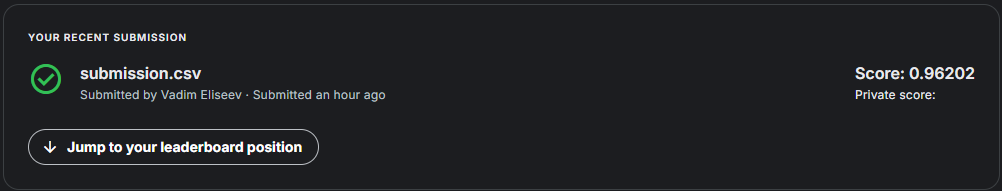

Как видно, натренированный нами классификатор хорошо справился с тестовыми данными, показав ROC AUC score превосходящий 96%